##### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

#################
# My notebook issues
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
sys.path.append('home/egupta/.local/bin')

##############

import os
import numpy as np
import scipy.stats as ss
import networkx as nx
import csv 
import numpy as np
import seaborn as sns
from pandas import DataFrame
from scipy.optimize import curve_fit
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline


##qtensor imports
import qtensor
from qtensor import QAOA_energy
from qtensor import parameter_optimization as popt
import torch

2021-07-15 07:54:31,799- WARNING•	QuickBB solver is unavailable
2021-07-15 07:54:31,801- WARNING•	Tamaki solver is unavailable: No path /home/egupta/.local/lib/python3.7/site-packages/thirdparty/tamaki_treewidth


# Data Collection Details

y = 5

x = 11*y

Use data stored in drive to generate subgraph_similarity_metric vs actual similarity for random graphs

All random graphs have 20 nodes but they differ in how many even degree nodes they have. There are a total of x graphs-- y of them with 0 even nodes, y with 2 even degree nodes , ..., y with all 20 even degree nodes. (Generating 20-node graphs with say odd number of even degree nodes like 3 even degree nodes was not possible ---it raised networkx.exception.NXUnfeasible )

Also when I say y graphs with same even degree nodes, they also have same degree sequence. But they are different i.e. non-isomorphic/

** Now debugging why some graphs, having different parity have high tranferability **

# Tranferability Matrices for Subgraphs
one of them uses the averaging technique, the other uses the best of 20 trick

# Why Mutual Tranferability
In the tranferability paper, we saw patterns in how even and odd subgraphs tranfer. But there was an important claim underlying that blue colormap: all the subgraphs was mutually tranferable. Well, that fact is trvial, but not so in our case, where we are not comparing subgraphs but larger random graphs. 

I'm calling a graph odd based on the number of even degree nodes it has. But that does not mean, like an odd subgraph, it is mutually tranferable. Let me repeat: Odd subgraphs are mutually tranferable. But "odd" graphs are not necessarily so!

Now in the paper, there were 3 conditions for tranferability:
1. Donor graph is mutually transferable
2. Acceptor graph is mutually transferable
3. All subgraphs in donor graph are tranferable to all subgraphs in acceptor graph.

My **hypothesis** is that conditions #1 and #2 affect number #3. Specifically, I claim that mutual tranferability of donor and acceptor graphs affects how well we can predict similarity between the pair. (i.e. **how close subgraph similarity metric is to actualy similarity**)

# Tranferability  Matrix for random subgraphs

In [2]:
def sub_all(d1, d2, draw=False):
    # returns a list of subgraphs of all graphs with nodes of the central edge having degree d1 and d2
    A = np.zeros((d1 + d2, d1 + d2))
    A[d1 + 1:, d1] = 1
    A[:d1 - 1, d1 - 1] = 1
    A[d1 - 1, :d1 - 1] = 1
    A[d1, d1 + 1:] = 1
    A[d1, d1 - 1] = 1
    A[d1 - 1, d1] = 1
    
    g = nx.from_numpy_matrix(np.array(A))

    g_list = [g]
    for i in range(min(d1, d2) - 1):
        g = g_list[i]
        g_list.append(nx.contracted_nodes(g, i, i + d1 + 1))
    # relabel center edge as (0, 1)
    for i, g in enumerate(g_list):
        g_list[i] = qtensor.tools.lightcone_orbits.relabel_edge_first(g, (d1 - 1, d1))
        if draw:
            nx.draw_kamada_kawai(g)
            plt.show()
    return g_list

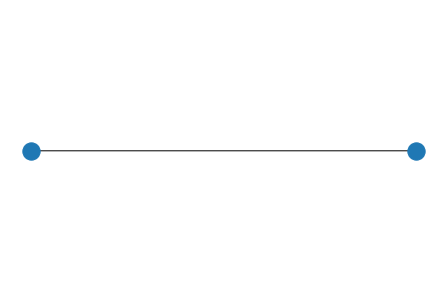

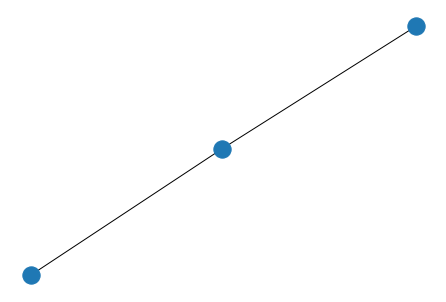

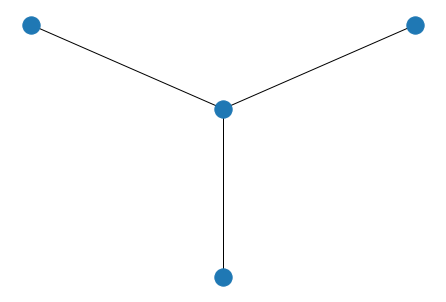

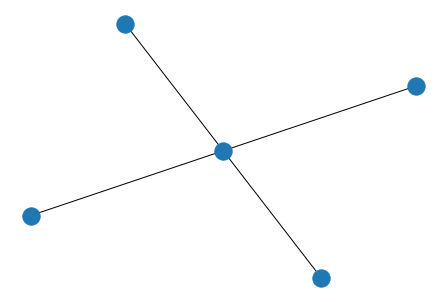

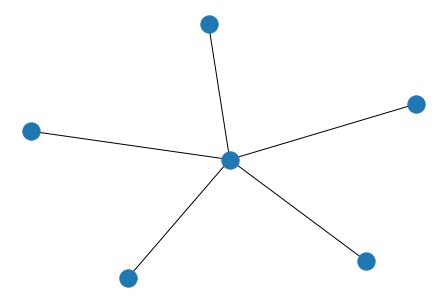

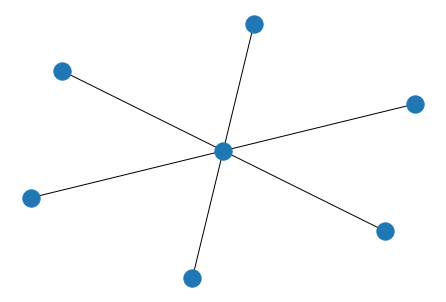

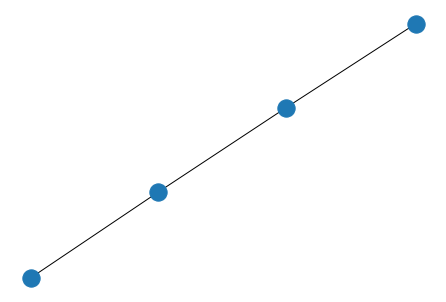

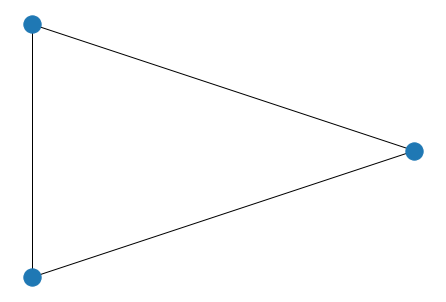

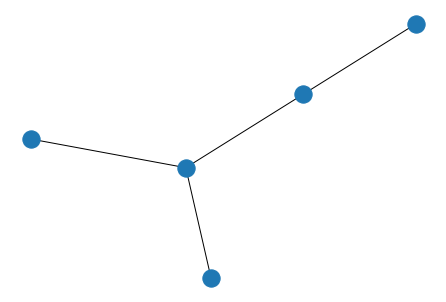

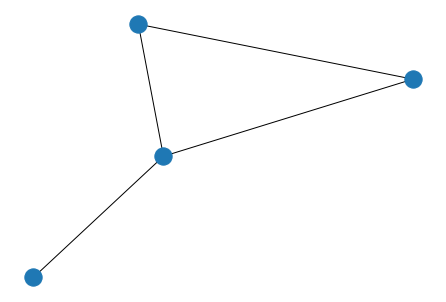

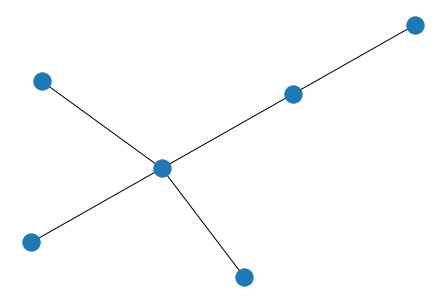

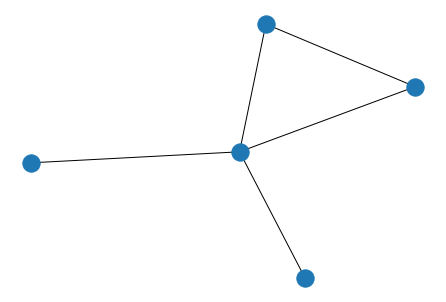

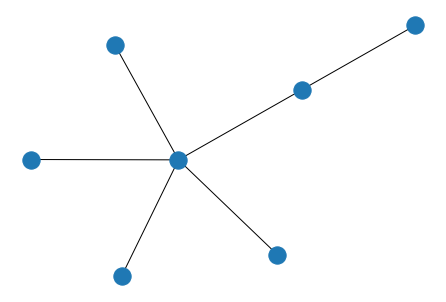

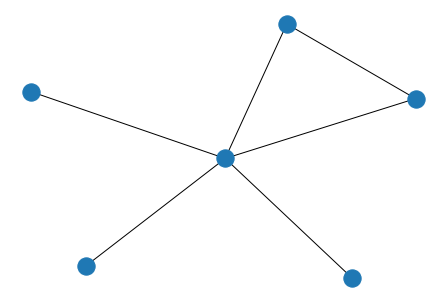

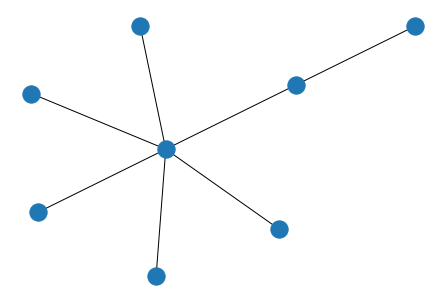

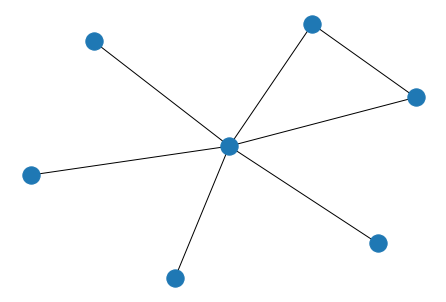

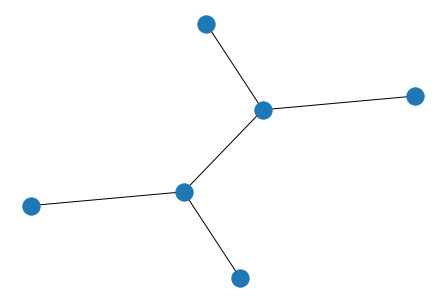

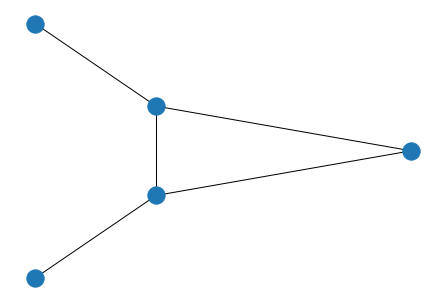

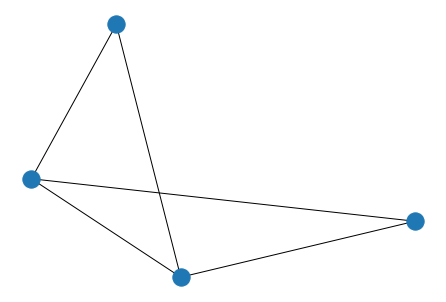

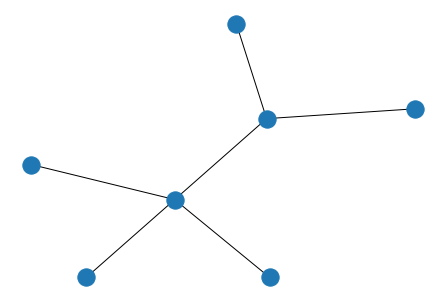

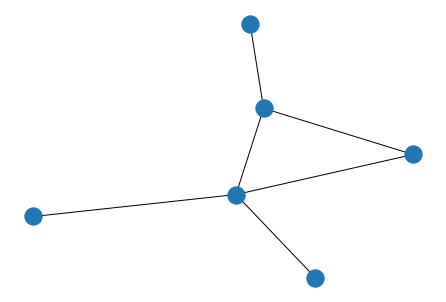

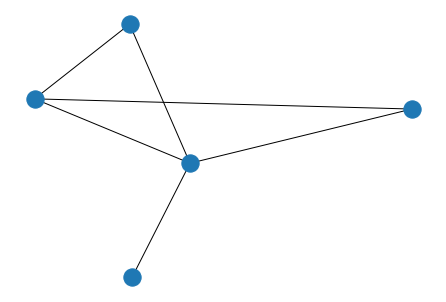

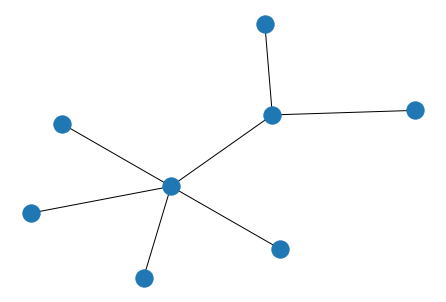

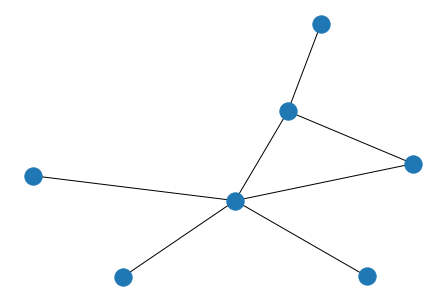

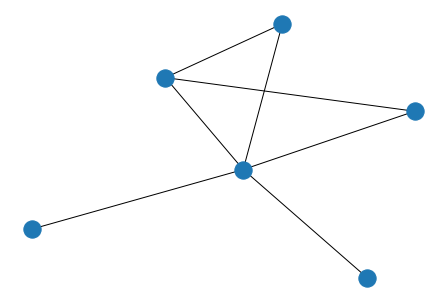

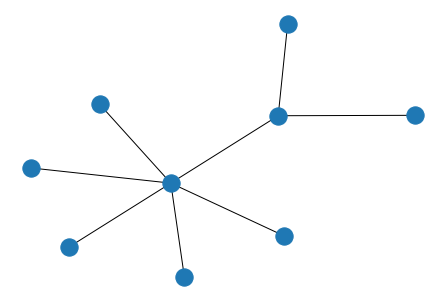

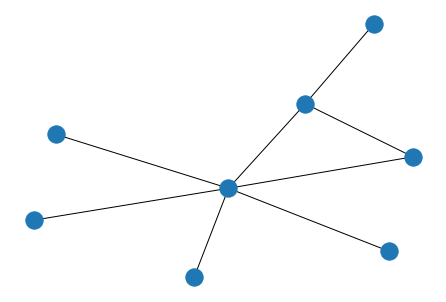

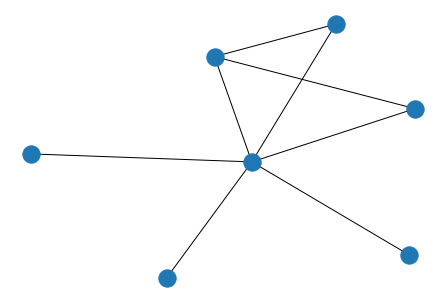

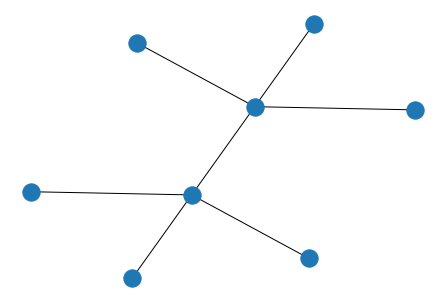

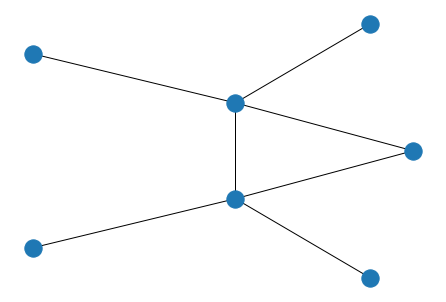

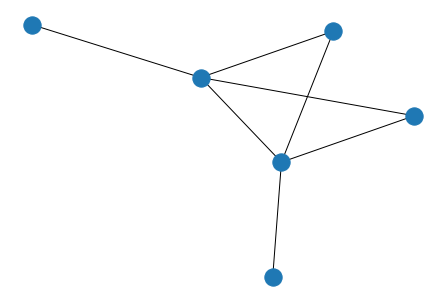

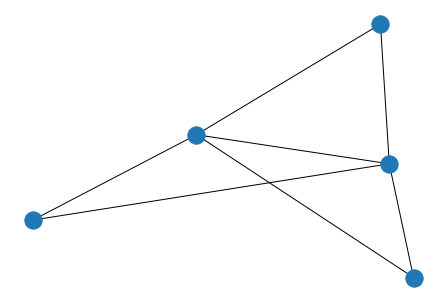

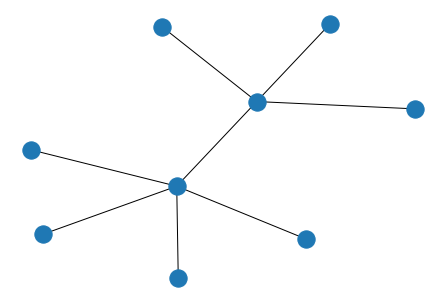

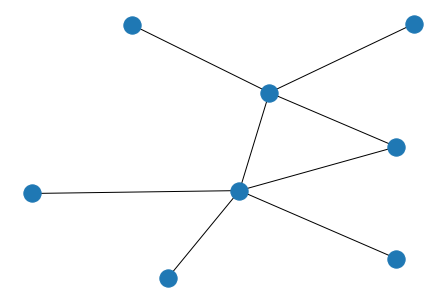

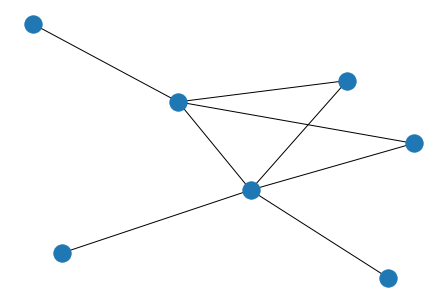

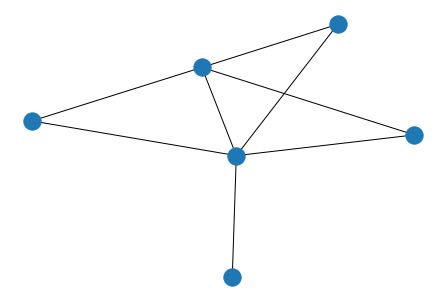

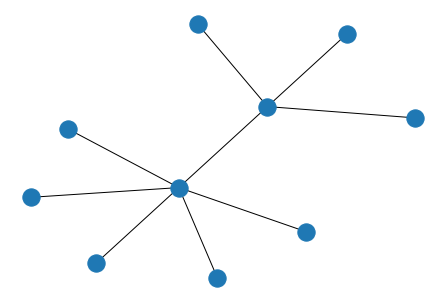

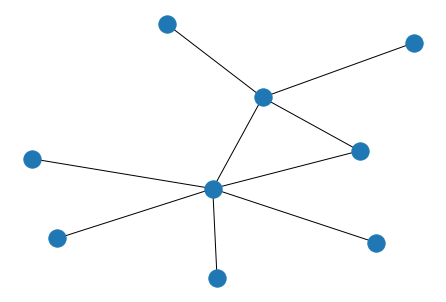

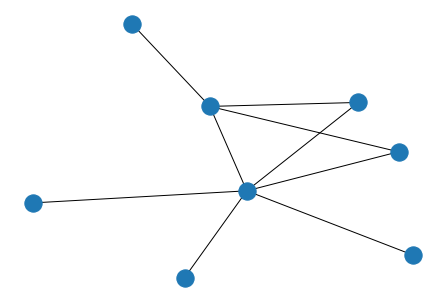

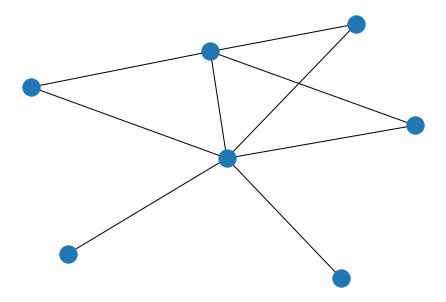

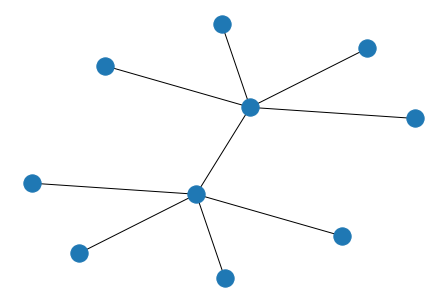

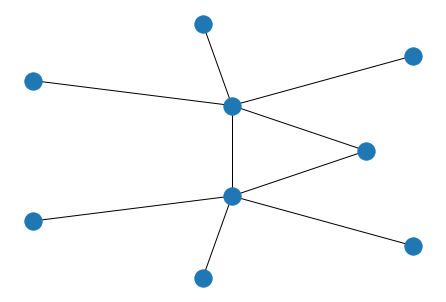

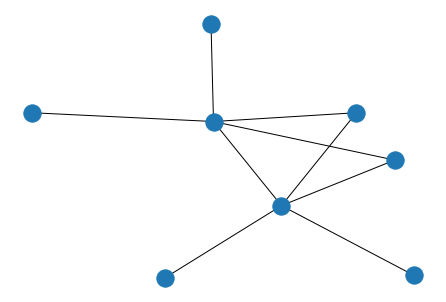

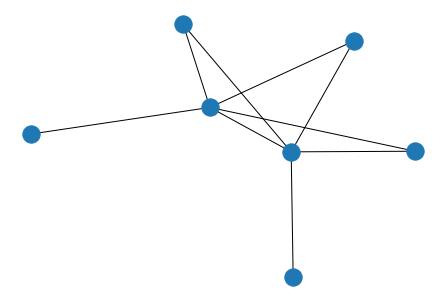

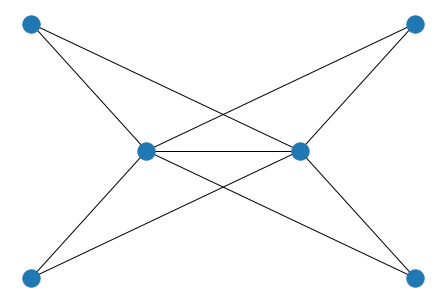

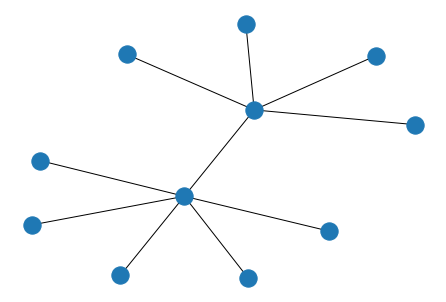

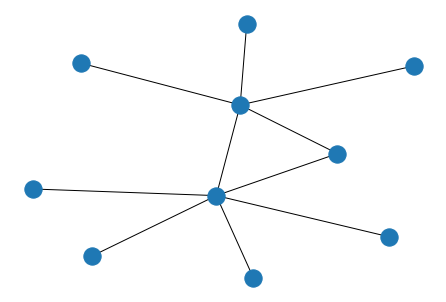

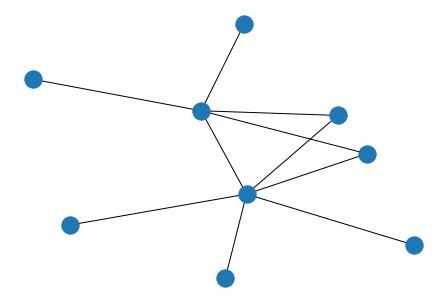

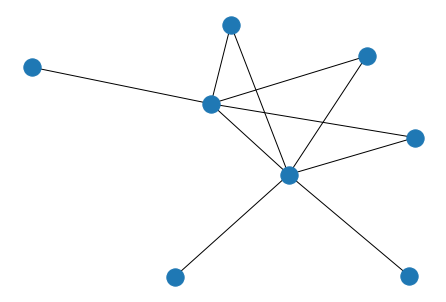

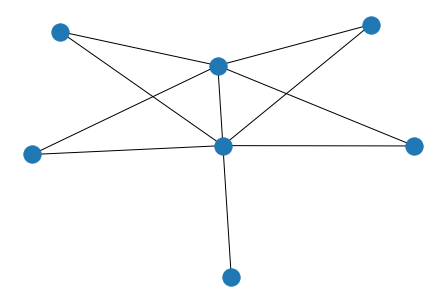

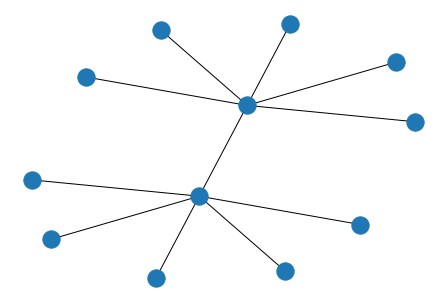

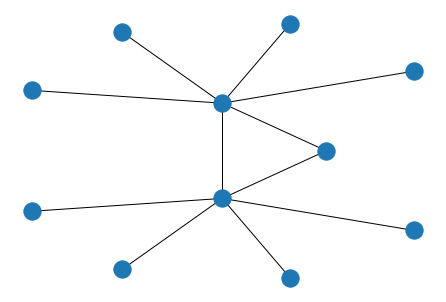

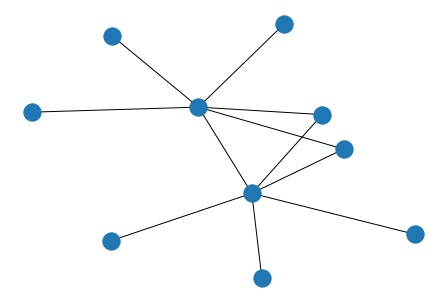

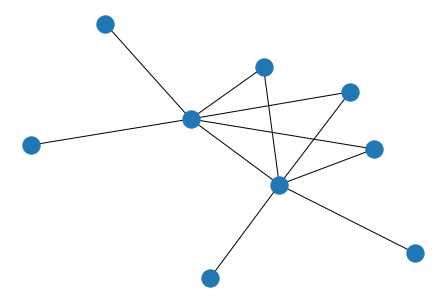

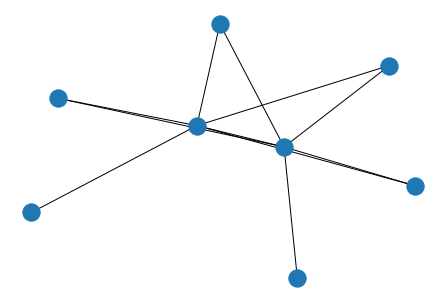

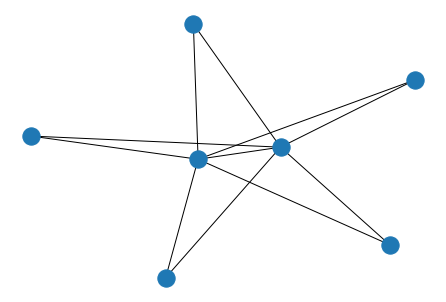

In [3]:
#generating all subgraphs first 
d_min = 1
d_max = 6
g_all = []
for i in range(d_min, d_max + 1):
    for j in range(i, d_max + 1):
        g_sub_ij = sub_all(i, j, draw=True)
        g_all += g_sub_ij

Get Data from a text file

In [4]:
file1 = open("/home/egupta/Documents/Eesh's Experiments/Transferability Matrices/transferability_matrix_random_subgraphs_6.txt")
file2 = open("/home/egupta/Documents/Eesh's Experiments/Transferability Matrices/direct_transferability_matrix_random_subgraphs_6.txt")

In [5]:
tranf_mat_orig = np.loadtxt(file1).reshape(56,56)
tranf_mat_mod = np.loadtxt(file2).reshape(56,56)

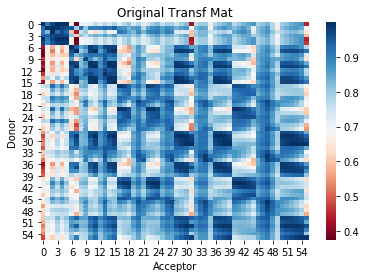

In [6]:
df = DataFrame(tranf_mat_orig)#, index=Index, columns=Cols)
sns.heatmap(df, annot=False, cmap="RdBu")
plt.title("Original Transf Mat")
plt.ylabel('Donor')
plt.xlabel('Acceptor')
plt.show()

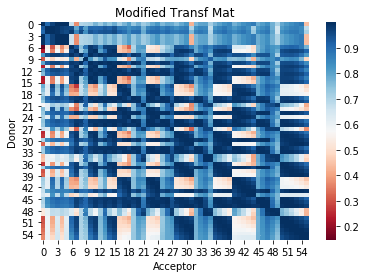

In [7]:
df = DataFrame(tranf_mat_mod)#, index=Index, columns=Cols)
sns.heatmap(df, annot=False, cmap="RdBu")
plt.title("Modified Transf Mat")
plt.ylabel('Donor')
plt.xlabel('Acceptor')
plt.show()

In [8]:
tranf_mat = tranf_mat_mod

# Identifying Subgraphs of a Graph

In [9]:
def find_index(g, subgraphs):
    """
    finds index of subgraph g is isomorphic with
    """
    i = 0
    while i<len(subgraphs):
        if nx.is_isomorphic(g, subgraphs[i]):
            return i
        i+=1
    print('error: could not find subgraph')
    return -1

In [10]:
def find_subgraphs(G):
  '''
  Input: A graph G
  Output: A dictionary containg subgraphs and their frequency in G
  '''
  edges_done = []
  subgraphs = {}

  vertices = G.nodes
  for v1 in vertices:
    ######print('----------------------------------------')
    ######print('Parent checking for vertex ' +str(v1) )
    neighbors = nx.all_neighbors(G,v1)
    ######print(neighbors)
    #iterate over edges
    for v2 in neighbors:
      ######print('Childchecking for vertex ' +str(v2) )
      ##if already there
      if (v1,v2) in edges_done:
        #######print('Already looked at')
        continue
      ##add if not there
      else:
        ######print('Not looked at')
        edges_done.append((v1,v2))
        edges_done.append((v2,v1))
      
      neighbors1 = nx.all_neighbors(G,v1)
      neighbors2 = nx.all_neighbors(G, v2)

      subg_edge_set = []
      for v in neighbors1:
        #######print(v)
        edge = (v1, v)
        subg_edge_set.append(edge)

      for v in neighbors2:
        ######print(v)
        if v is not v1:
          edge = (v2, v)
          subg_edge_set.append(edge)

      ##creating the subgraph
      H = G.edge_subgraph(subg_edge_set)

      ##check if isomorphic with any other subgraphs
      iso = False
      subgraphs_arr = subgraphs.keys()
      for subgraph in subgraphs_arr:
        if nx.is_isomorphic(H, subgraph):
          #######print('is isomorphic')
          subgraphs[subgraph] +=1
          iso = True
          break
      if iso == False:
        #######print('---------------Adding a subgraph--------------------')
        subgraphs[H] = 1
        ######print(subgraphs)
  return subgraphs

# Similiarity between 2 graphs

In [11]:
def similarity(G1, G2, subgraphs = g_all, tranf_mat = tranf_mat):
  """
  Compute similarity metric between 2 graphs
  """
  sub_g1_dict = find_subgraphs(G1)
  sub_g2_dict = find_subgraphs(G2)
  sub_g1 = sub_g1_dict.keys()
  sub_g2 = sub_g2_dict.keys()
  metric = 0
  total_arrows = 0
  dicty = {}

  for donor in sub_g1:
    for acceptor in sub_g2:
      arrows = sub_g1_dict[donor]*sub_g2_dict[acceptor]
      i = find_index(donor, subgraphs)
      j = find_index(acceptor, subgraphs)
      metric+= arrows*tranf_mat[i,j]
      total_arrows += arrows
    
      dicty[int(i*len(subgraphs)+j)] = arrows
  metric = metric/total_arrows

  for key in dicty.keys():
    val = dicty[key]
    dicty[key] = val/total_arrows
  return metric, dicty


** Different from that in other notebooks **

In [12]:
from qtensor import QAOA_energy

def actual_sim(G1, G2,g1_results, g2_results):
  """
  Returns similarity between two graphs computed directly
  """
  #Now computing similarity
  sim = 0
  acc_max_energy = g2_results[2]
  donor_gamma = g1_results[0]
  donor_beta = g1_results[1]

  transf_energy = QAOA_energy(G2, [donor_gamma], [donor_beta])
  #print(transf_energy)
  sim = transf_energy/acc_max_energy
  return sim


In [13]:
def mutual_similarity(G1, subgraphs = g_all, tranf_mat = tranf_mat):
  """
  Compute subgraph similarity metric within a graph
  """
  sub_g1_dict = find_subgraphs(G1)
  sub_g1 = sub_g1_dict.keys()
  metric = 0
  total_arrows = 0

  for donor in sub_g1:
    for acceptor in sub_g1:
      if (nx.is_isomorphic(donor, acceptor) is False):
        arrows = sub_g1_dict[donor]*sub_g1_dict[acceptor]
        i = find_index(donor, subgraphs)
        j = find_index(acceptor, subgraphs)
        metric+= arrows*tranf_mat[i,j]
        total_arrows += arrows
  metric = metric/total_arrows
  return metric


# Getting the graphs data

In [14]:
g_data = []
with open('20NodeRandomData1.csv', 'r', newline = '') as s:
  spamreader = csv.reader(s, quotechar='|')
  for row in spamreader:
    new_row = [float(i) for i in row]
    g_data.append(new_row)

In [15]:
resi = []
with open('20NodeRandomGraph1.csv', 'r', newline = '') as g:
  spamreader = csv.reader(g, quotechar='|')
  for row in spamreader:
    resi.append(row)

#convert bunch of rows to matrices
n = int(len(resi)/20)
mat_list = []
for i in range(n):
  array = []
  for j in range(20):
    row = resi[i*20 +j]
    row = [float(k) for k in row]
    array.append(row)
  mat_list.append(array)

In [16]:
def mats_to_graphs(mat_list):
  """
  Given list of adjaceny matrix repr of graphs, converts to actual graphs
  """
  g_list = []
  for mat in mat_list:
    arr = np.array(mat)
    G = nx.convert_matrix.from_numpy_matrix(arr)
    g_list.append(G)
  return g_list

In [17]:
g_list = mats_to_graphs(mat_list)

In [18]:
len(g_list)

55

In [19]:
len(g_data)

55

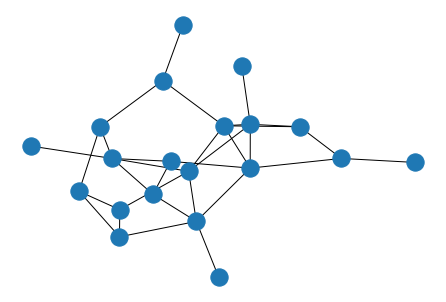

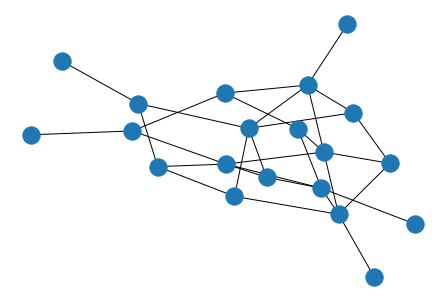

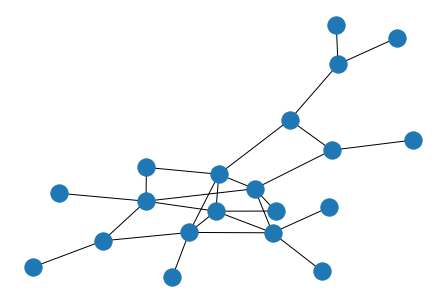

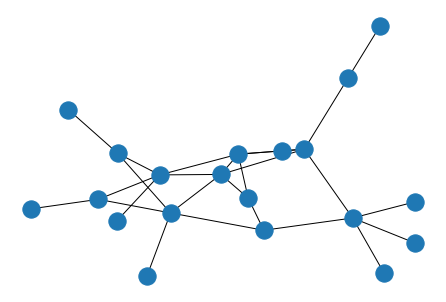

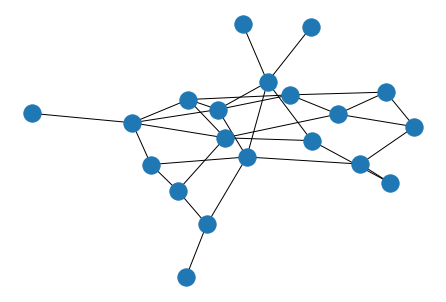

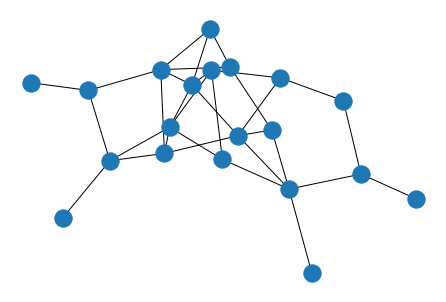

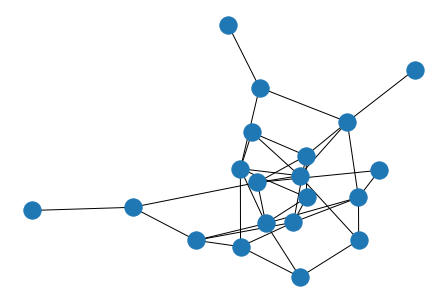

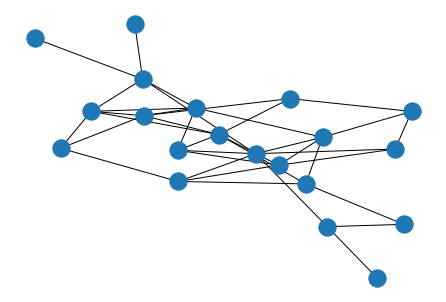

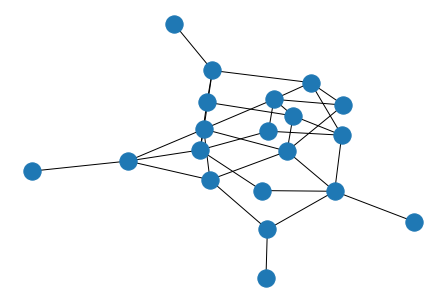

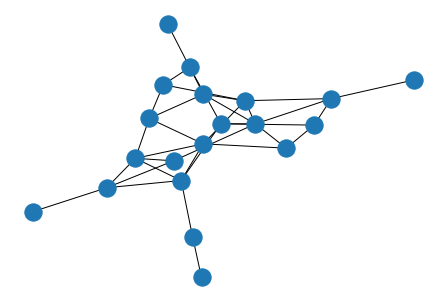

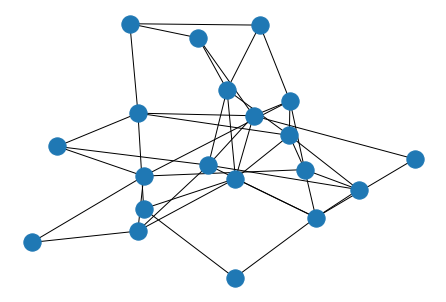

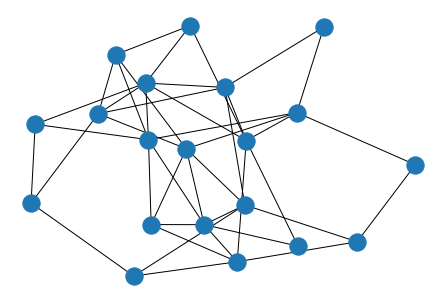

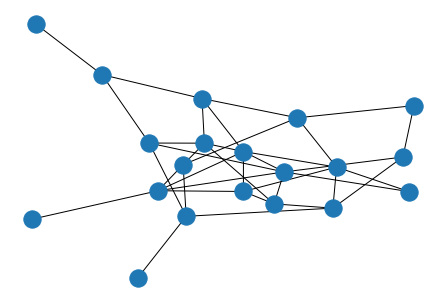

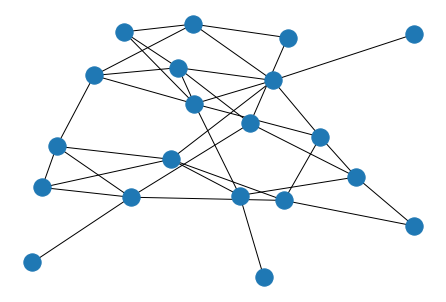

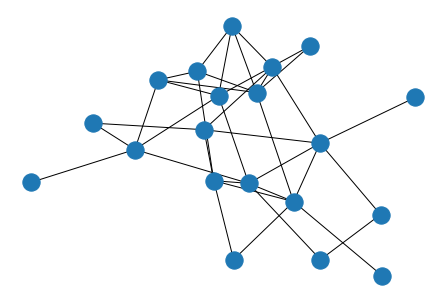

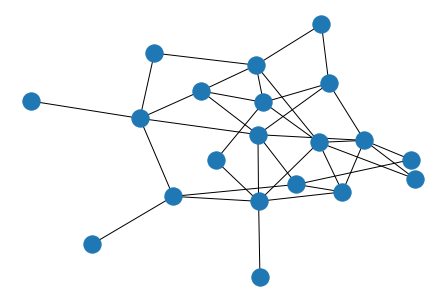

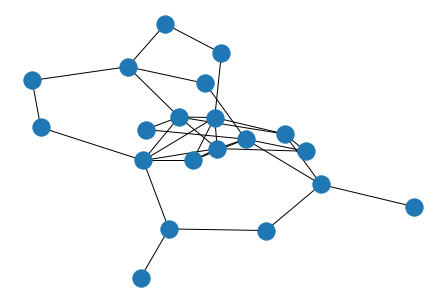

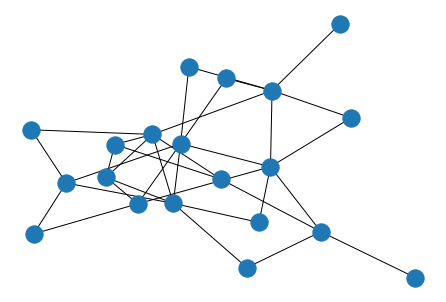

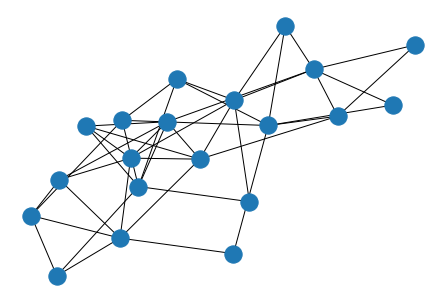

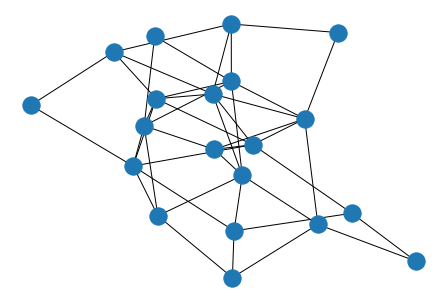

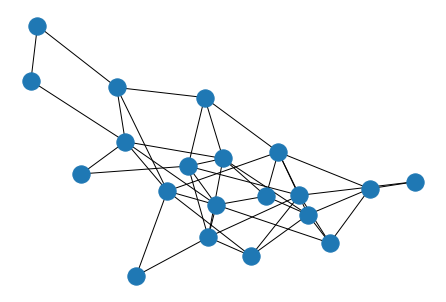

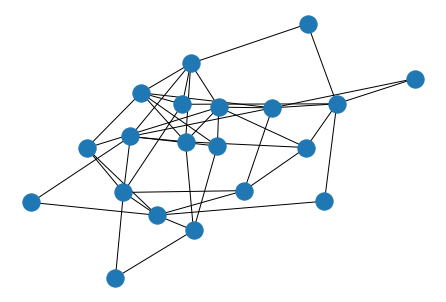

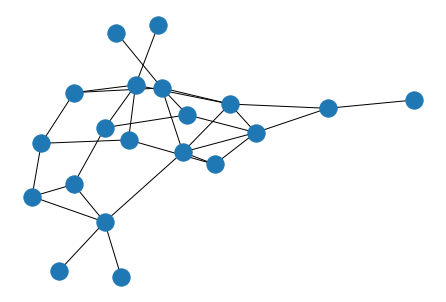

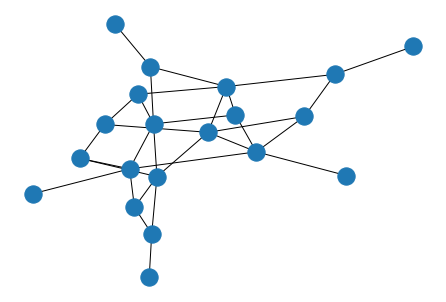

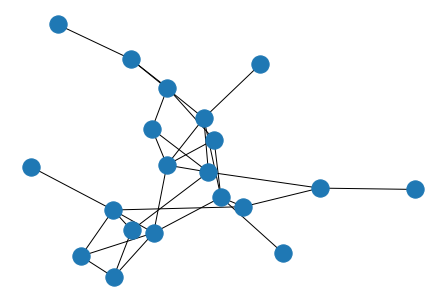

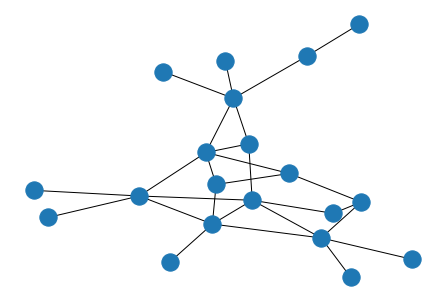

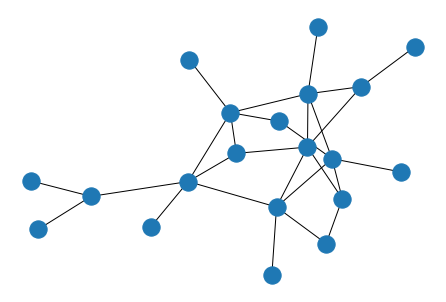

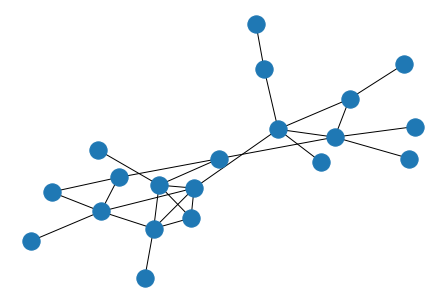

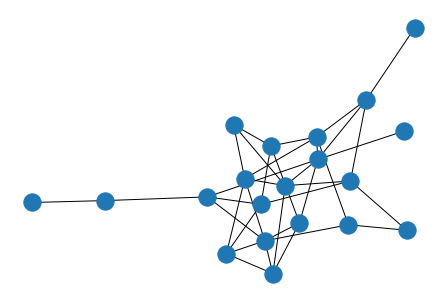

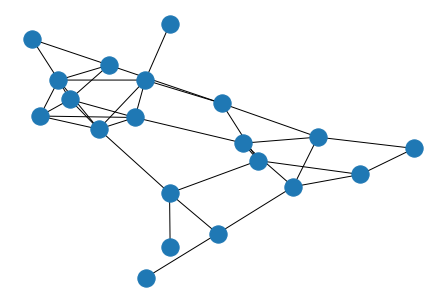

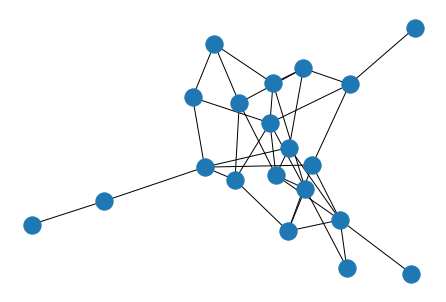

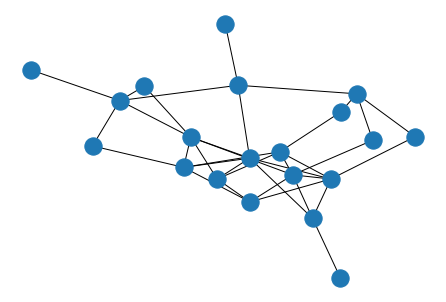

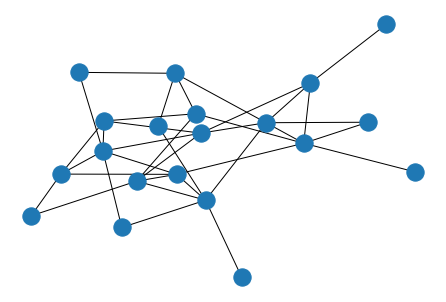

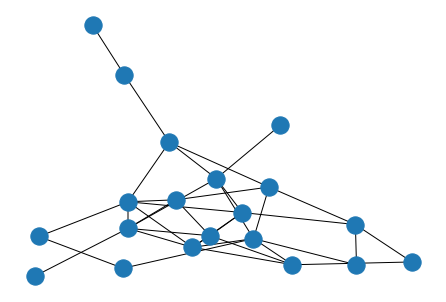

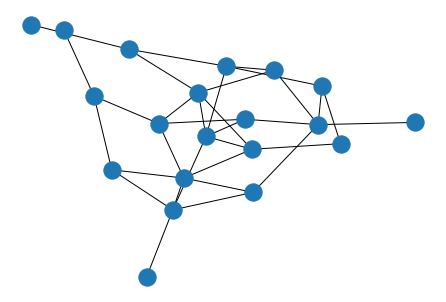

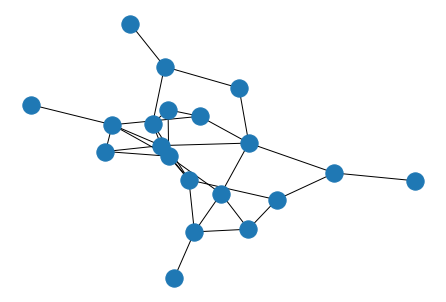

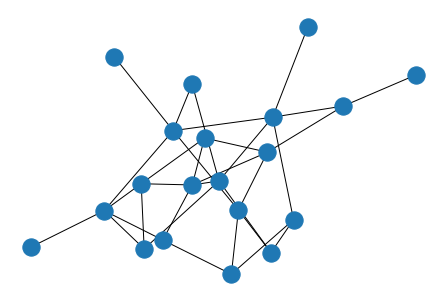

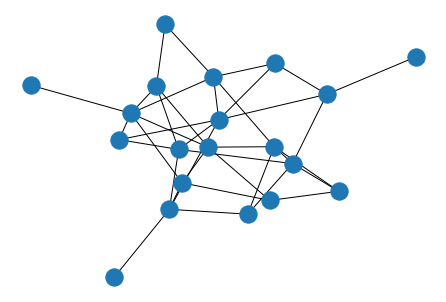

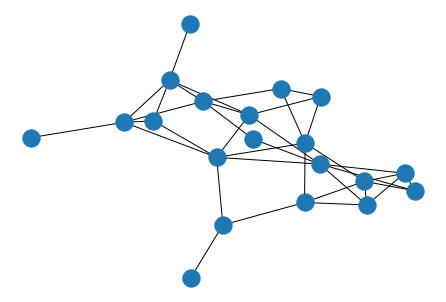

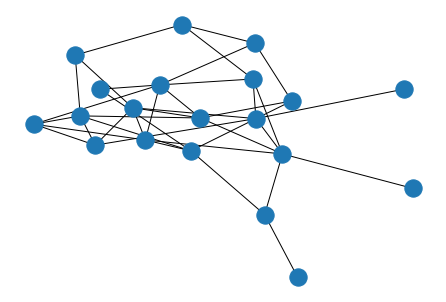

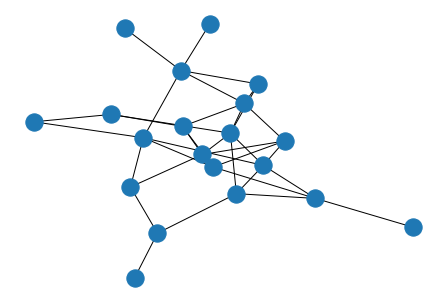

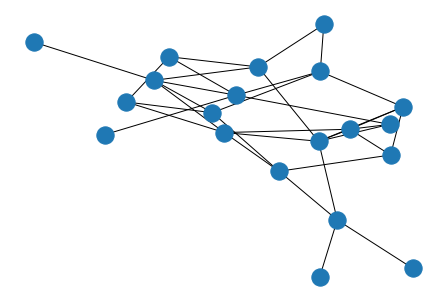

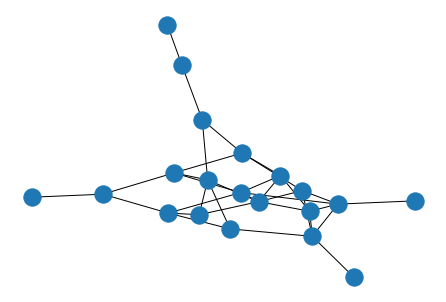

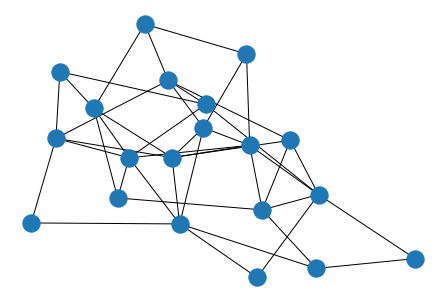

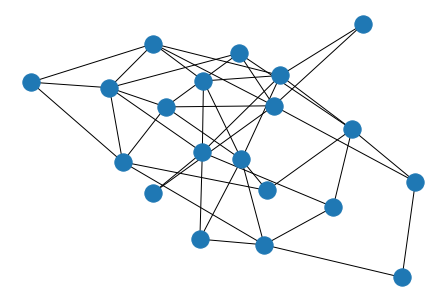

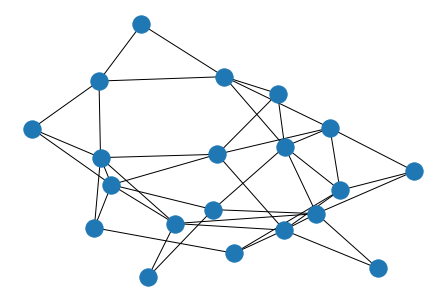

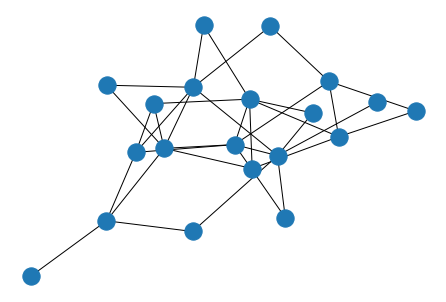

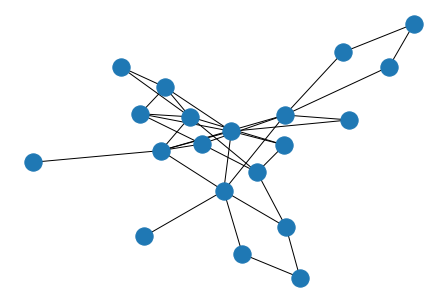

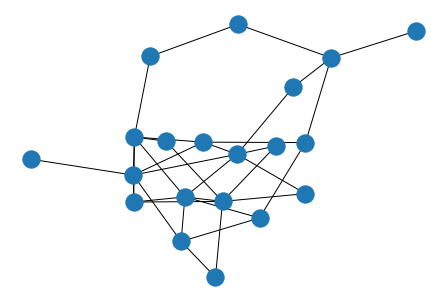

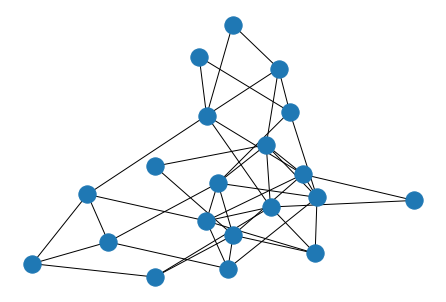

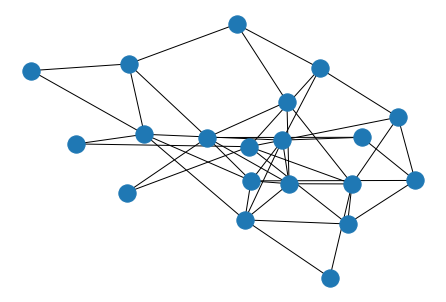

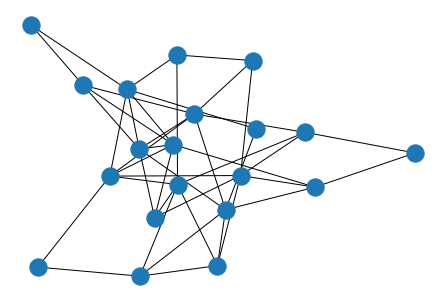

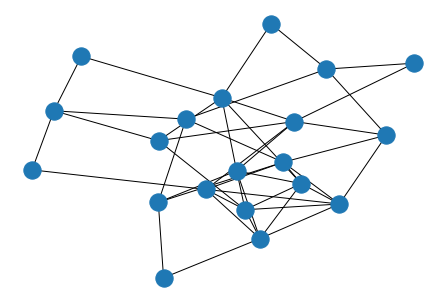

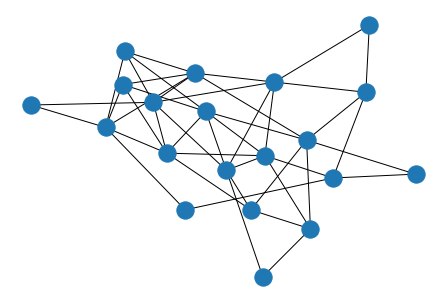

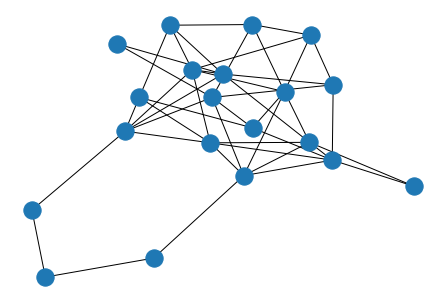

In [20]:
for i in g_list:
  nx.draw(i)
  plt.show()

In [21]:
g_data

[[0.9126172661781311, 1.117039442062378, 20.284748996816113, nan],
 [0.41105931997299194, 0.8794461488723755, 20.502635946285686, nan],
 [1.0940144062042236, 0.37760022282600403, 18.06639819799711, nan],
 [0.9066956639289856, 0.1187315508723259, 17.8600265973399, nan],
 [0.087131567299366, 0.8838310837745667, 20.864235941021242, nan],
 [0.08707757294178009, 0.3839203417301178, 20.858653064813797, nan],
 [0.9185823202133179, 0.620317816734314, 23.98091762961151, nan],
 [0.08134306967258453, -0.11820109188556671, 23.838427253934306, nan],
 [0.9150130748748779, 0.6199310421943665, 22.221382431992502, nan],
 [0.9150130152702332, 0.11757352948188782, 22.06849600305696, nan],
 [0.9226756691932678, 0.11800574511289597, 26.780676083932054, nan],
 [-0.07772380113601685, 0.11660400778055191, 26.679932189721374, nan],
 [0.9164245128631592, 1.1207950115203857, 23.45768101224793, nan],
 [0.08240549266338348, 0.8821668028831482, 23.257166818897765, nan],
 [0.08069731295108795, 0.38531967997550964, 2

In [22]:
mat_list

[[[0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   0.0],
  [0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0],
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0],
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [0.0,
   1.0,
   1.0,
   0.0,
  

# Plotting Similarity vs Actual Similarity



donor-acceptor pairs are either even-even or odd-odd



**
I'm calling certain graphs even -- those with 16, 18 or 20 even degree nodes-- and certain graphs odd -- those with 0, 2, 4 even degree nodes. The rest are reffered to as mix-parity**

#### Classifying graphs first

In [23]:
even_deg = [16, 18,20] 
odd_deg = [0,2,4]

In [24]:
#classifier
def even_or_odd(g, even_deg_nodes = even_deg, odd_deg_nodes = odd_deg):
  """
  Return 0 if a graph is classified as even, 1 if odd , -1 otherwise
  """
  degree_sequence = [d for n, d in g.degree()] 
  even_iter = 0
  for i in degree_sequence:
    if (i%2) ==0:
      even_iter+=1
  if even_iter in even_deg_nodes:
    return 0
  elif even_iter in odd_deg_nodes:
    return 1
  else:
    return -1

def classifier(g_list):
  """
  classifies some graphs as odd, others as even and remaining as mix; returns 
  indices of respective graphs in those bags
  """
  even=[]
  odd= []
  mix = []

  for i in range(len(g_list)):
    g = g_list[i]
    var = even_or_odd(g)
    if var ==0:
      even.append(i)
    elif var ==1:
      odd.append(i)
    else:
      mix.append(i)
  return even, odd, mix

In [25]:
# indices of graphs stores in g_list
even, odd, mix = classifier(g_list)

In [26]:
even

[16, 17, 18, 19, 20, 21, 46, 47, 48, 49, 50, 51, 52, 53, 54]

In [27]:
odd

[0, 1, 2, 3, 4, 5, 22, 23, 24, 25, 26, 27, 34, 35, 36]

In [28]:
mix

[6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 28,
 29,
 30,
 31,
 32,
 33,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45]

In [116]:
alll = [i for i in range(len(g_list))]

In [28]:
subgraphs = g_all 

master = []
n = len(subgraphs)
for i in range(int(n**2)):
    master.append([0,0,0])  ## uneighted, weighted, # of graphs

In [30]:
s_sim, dicty  = similarity(g_list[1], g_list[2])

### Run Funtion General

In [81]:
def run_general(A, B, graphs = g_list, g_results =g_data, subgraphs = g_all):
  """
  A, B are sets of indices for graphs between which we have to establish tranferability
  """
  xs = []
  ys = []
  a_ss= []
  s_ss = []
  #master = {}
  master = []
  n = len(subgraphs)
  for i in range(int(n**2)):
    master.append([0,0,0])  ## uneighted, weighted, # of graphs
  #datas = []


  #first tackling A-B graphs
  for i in A:
    donor = graphs[i]
    donor_results = g_results[i]
    #donor_sim = mutual_similarity(G1 = donor)
    for j in B:
    
      acceptor = graphs[j]
      acceptor_results = g_results[j]
      #acceptor_sim = mutual_similarity(G1 = acceptor)
      a_sim = actual_sim(donor, acceptor, donor_results, acceptor_results)
      s_sim, dicty  = similarity(donor, acceptor)
      a_ss.append(a_sim)
      s_ss.append(s_sim)
        
      booly = False
      print(a_sim)
      print(s_sim)
      if (a_sim>0.95) and (s_sim<0.95):
        booly = True
      for key in dicty.keys():
        u, w, g = master[key]
        if booly:
            u+=1
            w+= dicty[key]
            g+=1
        else:
            #print('hi')
            u-=1
            w+= -1*dicty[key]
            g+=1
        master[key] = [u, w, g]
        
      
      
  return a_ss, s_ss, master

In [117]:
alll

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54]

In [120]:
results = run_general(alll, alll)


[1.]
0.9577115406428122



[0.99967582]
0.9578175037697496



[0.99828077]
0.9213110351123579



[0.99909269]
0.9268814482670603



[0.99998229]
0.8974052272419579



[0.99997803]
0.895526940891302



[0.99866432]
0.8621169959846017



[0.99886003]
0.8616362947381532



[0.99966144]
0.8188917245243184



[0.99983019]
0.8267182037724056



[0.99674298]
0.8191044555993505



[0.99716669]
0.8235301849630776



[0.99926487]
0.759293806522914



[0.9992387]
0.7594401241040927



[0.99868035]
0.7325594975043006



[0.99900539]
0.731580660677095



[0.99992334]
0.6817610374331944



[0.99975154]
0.6901626461471316



[0.99439428]
0.6868050014932529



[0.99649746]
0.6834693620178952



[0.99531817]
0.6620063311669676



[0.9951649]
0.6638869960036461



[0.9999291]
0.9574950858081261



[0.99951842]
0.9577892610451765



[0.9998761]
0.957459821941788



[0.99912984]
0.9223527391461303



[0.99873531]
0.9222126941107449



[0.99921652]
0.92564835092524



[0.99926381]
0.7535911201124069



[0.99866147]
0.7563332799043943



[0.99923891]
0.756540185671016



[0.99910568]
0.7314918286203506



[0.99891782]
0.7349514619233383



[0.99929712]
0.732999499839157



[0.99967527]
0.8883299216657403



[0.99991098]
0.8927595345662079



[0.99979387]
0.8960201493244506



[0.99822427]
0.874230105709379



[0.9969908]
0.869477782637243



[0.9986811]
0.8645757164280183



[0.9996568]
0.8174134712209302



[0.99965451]
0.8197253127270683



[0.99978711]
0.8200908418810368



[0.99701336]
0.8225373256092416



[0.99669528]
0.8235050905708096



[0.99514891]
0.8343553340183829



[0.99942146]
0.6882486944816041



[0.99981073]
0.6841875858811024



[0.99987877]
0.6864600852246661



[0.99551134]
0.6891779416296637



[0.99622217]
0.6818036856195029



[0.99624643]
0.6845838162613171



[0.99553404]
0.6583381088904167



[0.9949671]
0.6615909032540124



[0.99539153]
0.6612178164603638



[0.99966933]
0.9588183184590398



[1.]
0.9595022307344119



[0.94958169]
0.924447814533532



[0.95827142]
0.9295766642122486



[0.91742859]
0.9018808095693723



[0.90296319]
0.8997306054017353



[0.85458314]
0.8681794311691274



[0.8516048]
0.8672923601733434



[0.78900892]
0.8269238707461667



[0.79794762]
0.8344157375139144



[0.78606628]
0.8268686970579481



[0.79226831]
0.8312517399618202



[0.69775824]
0.7699265500035258



[0.70255551]
0.7697218982868022



[0.65501343]
0.7434435706212488



[0.65357148]
0.7427526211906731



[0.58278598]
0.6946807486791182



[0.59192793]
0.7033239012474772



[0.5823343]
0.6994556390157964



[0.58185664]
0.6966725634952872



[0.54620827]
0.6759567548986536



[0.54924326]
0.6780520226598277



[0.99984773]
0.9587828722920676



[0.9999706]
0.9596142141709003



[0.99994781]
0.9589007807795866



[0.94920367]
0.9248636481925252



[0.94974043]
0.9252201786511353



[0.95857769]
0.9275251390501146



[0.68804132]
0.7638970889030783



[0.70952037]
0.7659301698605763



[0.69323546]
0.7670848828534371



[0.65364162]
0.742715223538644



[0.65686368]
0.7460140141134354



[0.66041256]
0.7440378666756631



[0.89278379]
0.8931054356251948



[0.89981351]
0.8974075171680469



[0.90676559]
0.9009399430057407



[0.86890772]
0.8795303743211784



[0.86783306]
0.8743522459700005



[0.85878566]
0.8706447748456442



[0.7878855]
0.8253370379696329



[0.79310014]
0.8276790968114421



[0.79255208]
0.8279757226512342



[0.7889985]
0.8304288257796587



[0.79132565]
0.8310556195779368



[0.80312839]
0.84141258941837



[0.58818204]
0.7014931815178412



[0.58560463]
0.697200363187266



[0.58792853]
0.699731257387656



[0.58990582]
0.7025856444815678



[0.5774894]
0.6947285859668615



[0.58340048]
0.6978688766621786



[0.54130865]
0.6719697465427656



[0.54444909]
0.6754464676803399



[0.54544298]
0.6751047352816096



[0.99814666]
0.9420335890484701



[0.99919918]
0.9424794063807594



[1.]
0.9168283179602221



[0.99970909]
0.9211703978979997



[0.99787498]
0.8914465279214103



[0.99783787]
0.8910297762623632



[0.99499664]
0.8610499730748987



[0.99491034]
0.8608044311199189



[0.99745879]
0.8274487951989862



[0.99726584]
0.8338387489326147



[0.9909879]
0.823530410453563



[0.99160358]
0.8276925810932904



[0.99661666]
0.7776255694059919



[0.99560543]
0.7767998545405804



[0.9942569]
0.7567339568912718



[0.9952343]
0.7559536657246918



[0.99794643]
0.7153691356382277



[0.99712887]
0.722206478364583



[0.98686809]
0.7154845024409452



[0.99057819]
0.7122536796963747



[0.98870159]
0.6945870077788519



[0.98866461]
0.6959790937373328



[0.99884859]
0.9424224799333508



[0.99910944]
0.9421213111740219



[0.99894786]
0.9421532960659214



[0.99968567]
0.9176455228437487



[0.99996278]
0.9175261969041917



[0.99814594]
0.9198032622514142



[0.9959883]
0.7727048577327609



[0.99403528]
0.7736731702647428



[0.99645312]
0.7751998983742158



[0.99550974]
0.7558137645292484



[0.995004]
0.7586909314731693



[0.99587855]
0.7561280527800024



[0.99902867]
0.88507435637059



[0.99863771]
0.8886381987382883



[0.99864891]
0.8910315430327913



[0.99310007]
0.871417203654691



[0.99080849]
0.8671365487138329



[0.99504593]
0.8630374558366654



[0.997386]
0.8259601186685748



[0.99745635]
0.8274248711498914



[0.99748846]
0.8282176156274623



[0.99172356]
0.8265754402410441



[0.99069102]
0.8274782873668171



[0.98786957]
0.8370287512863496



[0.99647998]
0.7204305484001063



[0.99719385]
0.7168442103489685



[0.99788558]
0.7192643460238306



[0.9891635]
0.7161987505494526



[0.98990588]
0.711465278998695



[0.99030778]
0.7128948774641614



[0.98891632]
0.6918350467999351



[0.98804362]
0.6944591805459579



[0.98876059]
0.693853046903254



[0.99895867]
0.9373203722315836



[0.99939446]
0.9367621740223002



[0.99970777]
0.9146425339676181



[1.]
0.9192547569623942



[0.99881549]
0.8925062052470566



[0.99879349]
0.8927746637564794



[0.99556568]
0.8670760001092654



[0.99574615]
0.8670944023828493



[0.99791447]
0.8374856835722471



[0.99803823]
0.8433584942200102



[0.99204592]
0.8347996285050521



[0.99276257]
0.83869282242548



[0.99699895]
0.7939062828971482



[0.99647224]
0.7932106662161111



[0.99554574]
0.7772288434721661



[0.99613176]
0.7761143263225521



[0.99889085]
0.739600068145495



[0.99790147]
0.7455651233756914



[0.98895576]
0.7428158258440039



[0.99177339]
0.7386128827604987



[0.99005071]
0.723721886562676



[0.98974631]
0.7246679597862892



[0.99944652]
0.9372506451570273



[0.99916789]
0.9362808002337537



[0.999387]
0.936806504240496



[0.99999954]
0.9161280663492485



[0.99982122]
0.9155196342913086



[0.99933631]
0.9190539406913232



[0.99666254]
0.7898823920536042



[0.99576397]
0.7906774595996526



[0.9968803]
0.7917613640232674



[0.99634117]
0.775942967206093



[0.99594789]
0.77850965007321



[0.99674961]
0.7755350434078171



[0.99920765]
0.8864061356499658



[0.99911222]
0.8900554065482512



[0.99897502]
0.8919080765352393



[0.99458066]
0.8772572514070374



[0.99290046]
0.8739559761135983



[0.99560694]
0.8687214567729454



[0.99786459]
0.8359789890707122



[0.99790473]
0.8369292845281674



[0.99807846]
0.8381222596614555



[0.99255827]
0.8372426435890883



[0.99199276]
0.8385355912844304



[0.98995942]
0.8482157945905674



[0.99714328]
0.7440620307009979



[0.99805928]
0.7407761847565763



[0.99846767]
0.7427017564863941



[0.99017884]
0.7418996197925724



[0.99152137]
0.7386059073772502



[0.99135787]
0.7389692314326612



[0.99067671]
0.7217602941505666



[0.98956067]
0.7239207908383416



[0.99017806]
0.7231127022616928



[0.99998159]
0.9022556784632657



[0.99951004]
0.90454671743943



[0.99798707]
0.8799473896021316



[0.99894034]
0.8840510875649253



[1.]
0.8722996135897763



[0.99999976]
0.8682254012677416



[0.9986354]
0.8518542021083111



[0.99889738]
0.8494828776455324



[0.99958188]
0.8228744750522563



[0.99982962]
0.8296543486599878



[0.99686075]
0.8268206414795829



[0.99731115]
0.8315628859337235



[0.99918122]
0.7867013261405682



[0.99927295]
0.7856816568828797



[0.99883592]
0.7674642309397207



[0.99906458]
0.7671069378522746



[0.99997682]
0.729657631006273



[0.99975973]
0.7388331976385185



[0.99477923]
0.7373476148670058



[0.99666279]
0.7351648746402761



[0.99553277]
0.7217594142811733



[0.99531166]
0.7242736398885005



[0.9998621]
0.9026557758259959



[0.99931776]
0.9051272952100827



[0.99976949]
0.9032755304307818



[0.99898328]
0.8780710097289826



[0.99847713]
0.8801290920820806



[0.99928278]
0.8795810686163421



[0.99925157]
0.7791749925941663



[0.99890861]
0.7819894061154451



[0.99916612]
0.7832850006740345



[0.99914825]
0.767189033877352



[0.99898824]
0.7700772747665745



[0.99935063]
0.7683201574717771



[0.99950785]
0.8625049485792242



[0.99981509]
0.8669201313443486



[0.99966081]
0.871586285489625



[0.99842032]
0.8616312081031896



[0.9973374]
0.85586151328312



[0.99865041]
0.8545469070875308



[0.99958286]
0.8208956786177445



[0.99957276]
0.8233396946537175



[0.99974153]
0.8239106992325603



[0.99707656]
0.8306492696898305



[0.99687434]
0.8307096313189083



[0.99552195]
0.840695158022531



[0.99939975]
0.7369869349743936



[0.99984224]
0.732199445012091



[0.99984199]
0.7353071804741917



[0.99562857]
0.7416295516652853



[0.99649168]
0.7327656410652761



[0.99637495]
0.7363915272327344



[0.99585068]
0.7172086869702605



[0.99522278]
0.7211544714677605



[0.99562281]
0.7207664033983505



[0.99997718]
0.9380157091641694



[0.99948796]
0.9390743871133655



[0.99794479]
0.9191365742902704



[0.99891412]
0.9214165049843314



[0.99999975]
0.912391930223029



[1.]
0.9129666280374182



[0.99864066]
0.9005396230938482



[0.99890913]
0.8990223746604018



[0.99957539]
0.8803203161513462



[0.99983103]
0.8838643734419255



[0.99688828]
0.88275902470288



[0.99733993]
0.8858620056748421



[0.99917704]
0.8543850915075163



[0.99928248]
0.8515746558529868



[0.99885959]
0.8410717683279664



[0.99907769]
0.8412556877173835



[0.99998041]
0.8152906369366317



[0.99976277]
0.8221483934256695



[0.99483646]
0.8212810757435633



[0.99669542]
0.8193411160654294



[0.99557302]
0.8095820482260879



[0.99534601]
0.8115077610099586



[0.99985052]
0.9380619150909182



[0.99929258]
0.9393132477216457



[0.99975409]
0.9383193631563115



[0.99895781]
0.9182306970476419



[0.99843985]
0.9195985059345785



[0.99928135]
0.9181193803770767



[0.99925588]
0.8498615434966814



[0.99893935]
0.8459799891478774



[0.99916342]
0.8523245503716046



[0.9991592]
0.8412408035540748



[0.99900289]
0.842961925337258



[0.99936165]
0.8393276104625149



[0.99948645]
0.9094274981175379



[0.99980215]
0.9120827652406065



[0.99964433]
0.9143665361834328



[0.99844994]
0.9062320933290159



[0.99738372]
0.9014947250698868



[0.99865538]
0.901820873094254



[0.99957713]
0.8784811379339409



[0.99956605]
0.878863672930713



[0.99973818]
0.8801650956220344



[0.99709768]
0.8854284193830532



[0.99690788]
0.8851290240223714



[0.99557652]
0.8918610554527763



[0.99940181]
0.8218536512831103



[0.99984708]
0.8171017327064714



[0.99983868]
0.8198175813270318



[0.99565931]
0.8232613774383989



[0.99653425]
0.81837465451518



[0.99640477]
0.8200971322473992



[0.99589877]
0.8060961120903801



[0.99526765]
0.8096063238026162



[0.99566439]
0.8086522713002245



[0.99878513]
0.9176723580401991



[0.99831167]
0.9189370702093734



[0.99568789]
0.8994476779320936



[0.99644204]
0.9015821257957176



[0.99875464]
0.8999537920432021



[0.99876115]
0.899868863486873



[1.]
0.8931705127548891



[0.9999155]
0.8910977580713625



[0.99959949]
0.8750669568427973



[0.9994796]
0.8785397763690577



[0.99933671]
0.88141571003588



[0.99931292]
0.8845458858753127



[0.99984685]
0.8554748760432312



[0.99985121]
0.8525071560919079



[0.99936321]
0.8439599536378767



[0.99982075]
0.8441669218554508



[0.99862964]
0.8199314079420557



[0.99961367]
0.8278200309812602



[0.99671094]
0.8294291500698789



[0.99898693]
0.8275879027614736



[0.9982774]
0.8199582793608462



[0.99859183]
0.8223120190637035



[0.99834928]
0.9174616262154471



[0.99837144]
0.9194895815219171



[0.99847463]
0.9180084028712773



[0.9965028]
0.8979782294435692



[0.99636366]
0.8999322526928074



[0.99646801]
0.8975927227549056



[0.99991418]
0.8503685956213974



[0.9984481]
0.8470181717169202



[0.99988025]
0.8531967264320417



[0.99985435]
0.844145450189512



[0.99979483]
0.8459949577470366



[0.99975383]
0.8423679768097747



[0.9984977]
0.8962505756994398



[0.99878213]
0.8990847176614033



[0.99884575]
0.9018678172798171



[0.99918395]
0.8986713473629443



[0.99779127]
0.8936692038076245



[0.99999992]
0.8946133390915968



[0.99962406]
0.8732018770316416



[0.99959618]
0.873675943855502



[0.99954129]
0.8750184343493376



[0.99957782]
0.8843045428931131



[0.99903379]
0.8837809627912094



[0.99715836]
0.8906294218337106



[0.99988003]
0.8278379896897754



[0.99945208]
0.8224237092834966



[0.99945531]
0.8251527090331681



[0.99889675]
0.8323990635681753



[0.99819538]
0.8260807094703988



[0.99909203]
0.8286222893236634



[0.99750084]
0.8155716330621283



[0.99789386]
0.8199189458697478



[0.99819752]
0.8188864041276697



[0.99892716]
0.9119379496894015



[0.998158]
0.9126526981349757



[0.99537549]
0.8976829310142375



[0.99643571]
0.8994906496118201



[0.99897998]
0.9012294400328216



[0.99899425]
0.9021512387948097



[0.99991367]
0.9003524334350356



[1.]
0.8984613041732138



[0.99952236]
0.8876207627454678



[0.99960171]
0.8901062415646588



[0.99946432]
0.8944940254966391



[0.99954502]
0.8972223299733927



[0.99971066]
0.8757306308392426



[0.99996261]
0.8724193162088925



[0.99974484]
0.8685574247232455



[0.99998291]
0.8687286125014262



[0.99897472]
0.8501805471552413



[0.99974152]
0.8569108554249719



[0.9974518]
0.8613330577592507



[0.99924131]
0.8591082969198904



[0.99860127]
0.8545941260844517



[0.99872107]
0.8565270700772132



[0.99842846]
0.9115479617269233



[0.99811998]
0.9130831426197327



[0.99845049]
0.9119496201461194



[0.99650657]
0.8964741361115277



[0.99610324]
0.8981803943563329



[0.9969362]
0.8961335613723672



[0.99992325]
0.8715722901715943



[0.99909927]
0.8669361713523486



[0.99976106]
0.873817827395733



[0.9999874]
0.8687067721560626



[0.99997453]
0.8700346706383343



[0.9999412]
0.8659351206110024



[0.9983244]
0.8989037558189839



[0.99875566]
0.9014428952614756



[0.99872076]
0.9035588174507065



[0.99961725]
0.90472564078432



[0.99856235]
0.9004412127365775



[0.99991171]
0.9013382960641155



[0.99955593]
0.8857044279819187



[0.99951361]
0.8855179486009789



[0.99955639]
0.8872622297175599



[0.9995922]
0.896803390383151



[0.99931967]
0.8963856220121708



[0.99789193]
0.9025731319003499



[0.99988028]
0.8572573973925403



[0.99965267]
0.8521761052119292



[0.99951799]
0.8546401231090693



[0.99895318]
0.8629373659313753



[0.99872558]
0.8583467124255769



[0.99923035]
0.8598216839286418



[0.99814451]
0.8509835582422473



[0.99830854]
0.8548406674641192



[0.99857246]
0.8536205834934425



[0.9996773]
0.8614015075971168



[0.99953149]
0.8627263324823435



[0.99774294]
0.8579584324554144



[0.99828155]
0.8591595496420489



[0.99959021]
0.8710671727372313



[0.99958303]
0.8711544538474244



[0.99958546]
0.880631889758798



[0.99952955]
0.8780595689547183



[1.]
0.8788822534229301



[0.99988886]
0.8806754676973433



[0.9980104]
0.8876972688380237



[0.99816991]
0.8906984210667838



[0.99992112]
0.8837251809205915



[0.99970502]
0.8799481720425789



[0.99894558]
0.8839135504135552



[0.99950362]
0.8840689980847347



[0.9994101]
0.8757066660447826



[0.99987431]
0.8819032534053537



[0.99505303]
0.8890023459686643



[0.99762342]
0.8865926982243664



[0.9965785]
0.888296437423275



[0.99677148]
0.8900924857261524



[0.99950764]
0.8612419025202287



[0.99954265]
0.8632893706748379



[0.99961124]
0.8617949690909879



[0.99831913]
0.8556909830691138



[0.99824357]
0.8581416778934847



[0.99797729]
0.8548624485905604



[0.9998274]
0.8790307644361807



[0.99835805]
0.8752576626344596



[0.99990458]
0.881547670233247



[0.99960298]
0.8841122878872733



[0.99942597]
0.884997002870433



[0.99963327]
0.8809694321073102



[0.99962925]
0.8683102662374519



[0.9997644]
0.8708562629356413



[0.99980109]
0.873350799859085



[0.99856832]
0.8840664953247452



[0.99699358]
0.8799925744017795



[0.99959675]
0.881602413731552



[0.99999933]
0.8767493825270026



[0.99999991]
0.8763606422667739



[0.99997557]
0.87850615739619



[0.9983618]
0.8899207667617401



[0.99773015]
0.889436817471307



[0.99568737]
0.895534313613435



[0.99988882]
0.882169635005631



[0.99978633]
0.8772283650455285



[0.99994017]
0.8798094901144294



[0.99715699]
0.8900441342095617



[0.99691913]
0.8861309923602076



[0.99760872]
0.8870491102765181



[0.99614477]
0.8850921772643329



[0.99614078]
0.8886708124437209



[0.99655086]
0.8873557359545079



[0.99983251]
0.8916843703286242



[0.99935457]
0.8927744536102785



[0.99739909]
0.8836904810111388



[0.99828036]
0.8852180354287748



[0.99983456]
0.890250472534735



[0.99983611]
0.8906833873269889



[0.99944823]
0.8935395282880603



[0.99958172]
0.8912937677785461



[0.99988988]
0.8860566228282704



[1.]
0.8882414033523172



[0.99809154]
0.8927384108574742



[0.99836519]
0.8955892072099257



[0.99973382]
0.8814290518476541



[0.99979483]
0.8779271762987032



[0.99932618]
0.8775704341080268



[0.99963959]
0.8777603574945474



[0.9997615]
0.8634705934763988



[0.99998922]
0.8699841741351549



[0.99580688]
0.8746255683435775



[0.99783476]
0.872351547515794



[0.99685954]
0.8706410179511207



[0.99683791]
0.8725318522707208



[0.99959026]
0.8914684376800774



[0.99925751]
0.8932567117683023



[0.99957918]
0.8919385276485419



[0.99832938]
0.8819057398848753



[0.99795925]
0.8840063934922868



[0.99850728]
0.881352606989943



[0.99980295]
0.8769686830199518



[0.99904693]
0.8726965028701835



[0.99973662]
0.8793685085243382



[0.99970605]
0.8777709256555601



[0.99958188]
0.8788899011874006



[0.99979538]
0.8747967416004532



[0.99942746]
0.8876444666043407



[0.99972733]
0.8902212538744134



[0.99965475]
0.8925591040329739



[0.99900994]
0.8974716444638068



[0.99781203]
0.8932465863927702



[0.99945732]
0.8945390606259828



[0.99989944]
0.8840125711034297



[0.99988376]
0.8837689110511473



[0.99996758]
0.8856568667865102



[0.99831625]
0.8949979232788693



[0.99798662]
0.8945345921847436



[0.99644226]
0.9006901077459719



[0.99986445]
0.8702638618714386



[0.99998138]
0.865228021490801



[0.9999805]
0.8678033808059212



[0.99715247]
0.8760279422639574



[0.99743565]
0.8717288493786208



[0.99769247]
0.8729406337970254



[0.99677733]
0.8672563898933532



[0.99652306]
0.8709364164187724



[0.99688807]
0.8696860357244862



[0.99701973]
0.8300280522887907



[0.99577297]
0.8322858949812341



[0.99207867]
0.8219392247870393



[0.99352087]
0.8240513089027792



[0.99718349]
0.844906366116019



[0.99721829]
0.8418230840109363



[0.99933101]
0.8547188531306327



[0.99948482]
0.8510925774631924



[0.99805479]
0.8489301770273056



[0.99824148]
0.8525200072547718



[1.]
0.8644912462361493



[0.99995742]
0.8684102895344772



[0.99857516]
0.8540650188304625



[0.99918379]
0.8510841961099347



[0.99947572]
0.8521473703364396



[0.99948877]
0.8520640176115294



[0.99743149]
0.8390293870041228



[0.99860522]
0.8476724149858227



[0.99871169]
0.8572618296441107



[0.9999313]
0.8548463189822056



[0.99970953]
0.8561802313585513



[0.99983849]
0.8587812883443631



[0.99623481]
0.8298232948789451



[0.9957237]
0.8333613052936765



[0.99621881]
0.8308809497485964



[0.99362253]
0.8185438874197617



[0.99300825]
0.8219665150549976



[0.99461324]
0.8183515793640778



[0.99903288]
0.8471556349608426



[0.9985619]
0.8473629990381106



[0.99868599]
0.8509627314745202



[0.99940554]
0.8521347574039132



[0.99954293]
0.8538347067493685



[0.99926004]
0.8508137807126441



[0.99601304]
0.8376996410530925



[0.99667367]
0.8414096765867544



[0.99660796]
0.8457123437346363



[0.99953222]
0.8602130224952512



[0.99885241]
0.8552467277574035



[0.99931759]
0.8566247090753955



[0.99811954]
0.8466735576873146



[0.99803686]
0.8475053155076465



[0.99811035]
0.8493494538822361



[0.9999536]
0.867588146063986



[0.99992601]
0.8670652359558094



[0.99891403]
0.8750714831927662



[0.99891732]
0.8474012802771643



[0.99848201]
0.8416823361591821



[0.99812407]
0.844563221209928



[0.99990542]
0.8606616958759556



[0.99947643]
0.8530133972693775



[0.9999763]
0.8558704379986013



[0.99906704]
0.8513804753389487



[0.99952061]
0.8561350744613806



[0.99965154]
0.8550337086295678



[0.997243]
0.8866972487531594



[0.99586211]
0.8878191768223328



[0.99216643]
0.8751944063927782



[0.99376096]
0.8765716303005148



[0.99744966]
0.890608570173776



[0.99748687]
0.890956475668459



[0.99927126]
0.8988918451705561



[0.99952862]
0.896293498638374



[0.99809605]
0.8922078159095336



[0.99839965]
0.8941057932928227



[0.99995858]
0.9042736891528851



[1.]
0.9070050471599281



[0.99854567]
0.89271781932323



[0.99927195]
0.8889710976305679



[0.99968422]
0.8899663783313181



[0.99958156]
0.890256350685293



[0.99776144]
0.8786669490151626



[0.99874137]
0.8855536076587573



[0.99898936]
0.8944417015909004



[0.99996083]
0.8923165867691704



[0.99973902]
0.8920169946661421



[0.99973904]
0.8940988352064857



[0.99645235]
0.8862409320906397



[0.99575044]
0.88851741697419



[0.99637355]
0.8868956099039461



[0.99386529]
0.8731284549037991



[0.99310468]
0.8755328837908445



[0.99508961]
0.8723547720273994



[0.99906776]
0.8881936832731712



[0.99897393]
0.8834330378025532



[0.99866002]
0.89067641705783



[0.99949044]
0.8902908430492349



[0.99963934]
0.8913007807211413



[0.99939298]
0.8871615297185864



[0.99608271]
0.8880832443230181



[0.99681073]
0.8906630553458331



[0.99668448]
0.8931597777687428



[0.99975071]
0.9022520332282744



[0.99924539]
0.8979037320302115



[0.99925801]
0.8998262432058827



[0.99816274]
0.8901037876020333



[0.99807581]
0.8897604889426954



[0.99820919]
0.8917973839963007



[0.99985969]
0.9065580036327889



[0.99997948]
0.9058932408775845



[0.99920955]
0.9117957191515075



[0.99894836]
0.8861217506314489



[0.9986702]
0.8807555116945258



[0.99824972]
0.8833090613138743



[0.99977217]
0.8963754085099278



[0.99967979]
0.8914383706706617



[0.99992253]
0.8930375682576235



[0.99933083]
0.8881429183739115



[0.99959682]
0.8922971522941077



[0.99971846]
0.8909833198850541



[0.99932049]
0.8006343977947404



[0.99914863]
0.8028764623721297



[0.99707322]
0.811531341878605



[0.9975876]
0.8112741737618655



[0.99922647]
0.8444766238041432



[0.99922169]
0.8441809006722919



[0.99984344]
0.8737485989422956



[0.99971386]
0.8699961835548448



[0.99992405]
0.8897315794677539



[0.99973637]
0.8896883042945181



[0.99856037]
0.9043750926770624



[0.99860789]
0.9072595658423606



[1.]
0.9238690507320895



[0.99978295]
0.9187916224553762



[0.99903045]
0.936213883336095



[0.99962795]
0.9366296021664688



[0.99902239]
0.9458602868681857



[0.99977414]
0.9515387720215156



[0.99551338]
0.9637176595691794



[0.99814202]
0.961394471856



[0.99720675]
0.9735880186865845



[0.99751966]
0.975395663472459



[0.99906476]
0.8006968185381763



[0.99921559]
0.8037342017053083



[0.99921498]
0.80157426278373



[0.9976306]
0.8074735317943852



[0.99762569]
0.8112623598770121



[0.99724387]
0.8053325880740209



[0.99991803]
0.9188557386724988



[0.99821761]
0.9142617136553092



[0.99999729]
0.9215862119733385



[0.99971202]
0.9367175023116987



[0.99956466]
0.9367579720291522



[0.99966972]
0.9322566106163696



[0.99929099]
0.8425965202490171



[0.99943302]
0.8448101679465727



[0.99951675]
0.8475450831259083



[0.9987178]
0.8744645313551862



[0.99709324]
0.8706351465758686



[0.99985073]
0.8744175715409346



[0.99993018]
0.8872476390256319



[0.99992497]
0.8860980877125956



[0.99985204]
0.8890436881375302



[0.99890851]
0.9062963400911561



[0.99821299]
0.9053903733579929



[0.99607534]
0.9103893042366734



[0.99993735]
0.9522856836461909



[0.99963019]
0.9470308078367639



[0.99977301]
0.9498591499541373



[0.99789945]
0.9643055069928017



[0.99730314]
0.9612682101521818



[0.9982176]
0.9615862163340699



[0.99652125]
0.970448472979797



[0.99675806]
0.9742198029505555



[0.99714013]
0.9725636576896618



[0.99927861]
0.8270017443215482



[0.99857291]
0.8293203475243958



[0.99601403]
0.8343325312060934



[0.99704259]
0.8343547064925841



[0.99932193]
0.8611134439743389



[0.99933278]
0.8605626191007072



[0.99985093]
0.8845048310094256



[0.99996159]
0.8807916112677818



[0.99970275]
0.8952941816532037



[0.99980308]
0.8957130591452475



[0.99915067]
0.9075701755098264



[0.99929327]
0.9104330583507977



[0.999787]
0.9206184425760228



[1.]
0.9158062093476121



[0.99972085]
0.9284590106896953



[0.99996681]
0.9290029788688218



[0.9992965]
0.9322705872876147



[0.99989387]
0.9385135983386681



[0.997096]
0.9487207131400559



[0.99892333]
0.9467975945945994



[0.9981889]
0.9557611128396867



[0.99825601]
0.9578033894763505



[0.99884812]
0.8270344290064308



[0.99851227]
0.8302356489933514



[0.99885431]
0.8279518654087237



[0.99710762]
0.8303740901251593



[0.99669713]
0.8341209934359929



[0.99749479]
0.8283705405231835



[0.9999673]
0.9153935043683454



[0.99920448]
0.9106184997078222



[0.9998247]
0.9182763158559969



[0.99998781]
0.9291266916316188



[0.99994527]
0.9293655425863578



[0.99998387]
0.9250182136063836



[0.99871215]
0.8588873619930019



[0.99911514]
0.8612295444008958



[0.99906345]
0.864188109901755



[0.99954613]
0.8856480027209587



[0.9984712]
0.8813515917247815



[0.99985193]
0.8853211355523003



[0.9997299]
0.8928211109355104



[0.9996947]
0.89203723757322



[0.99975479]
0.894595746822254



[0.99929921]
0.9096890002182461



[0.99902701]
0.908647484140733



[0.99759444]
0.9137235678389843



[0.99994956]
0.9391938228926352



[0.99983303]
0.9337715045229107



[0.99972761]
0.936707899523653



[0.99850972]
0.9502798575371062



[0.99845925]
0.9462456383660234



[0.99886716]
0.9472013403998293



[0.99786219]
0.9522248947770532



[0.99788951]
0.9562074301893599



[0.99818034]
0.9547016599083088



[0.99855451]
0.7612923209754934



[0.99724639]
0.7624833783834114



[0.99408164]
0.7730944949794185



[0.99568462]
0.7741608977246152



[0.9987578]
0.8111808003512402



[0.99878708]
0.810126660921356



[0.99937103]
0.8433144102840016



[0.99974211]
0.8399919986134096



[0.99886678]
0.8606074259150731



[0.99928156]
0.8614944140707373



[0.99942767]
0.8787582537488002



[0.99966164]
0.8821471218133136



[0.99901099]
0.8990091707051516



[0.99970858]
0.8950361160975862



[1.]
0.9155668836378362



[0.99985455]
0.9150213940220651



[0.99899597]
0.9255622865666336



[0.99946258]
0.9304304987999445



[0.99850719]
0.9477737988631539



[0.99943662]
0.9435551572836627



[0.99896896]
0.9580257804007533



[0.99877505]
0.9591261116494452



[0.99791732]
0.7610465537475047



[0.99704922]
0.7630844250948008



[0.99776767]
0.7616441644408247



[0.99577559]
0.7699102172342925



[0.99491882]
0.772906770485778



[0.99702688]
0.7699162386583617



[0.99948936]
0.8942078109726196



[0.99974918]
0.8931641844997275



[0.99909647]
0.8966139410540993



[0.9998011]
0.91505179175564



[0.99988242]
0.9152681887966391



[0.99983006]
0.9111481150333136



[0.99739267]
0.806750481284625



[0.99809029]
0.8097979480292913



[0.99789241]
0.812455684596644



[0.99997795]
0.8461174078131938



[0.99951715]
0.8436345496888404



[0.99936453]
0.8441057700600776



[0.9989188]
0.8581382806033006



[0.99884822]
0.8570805449042705



[0.99905242]
0.8604519564596056



[0.99935018]
0.8802550213332577



[0.99954785]
0.880389655863991



[0.99889786]
0.8872997828374908



[0.99941742]
0.9306011810163559



[0.99948707]
0.9262208220569091



[0.99910087]
0.92843070484422



[0.99886176]
0.946022841497198



[0.99937544]
0.9442944141450625



[0.99924489]
0.9433482889258142



[0.99900743]
0.9560014362511797



[0.99883656]
0.9589430328152432



[0.99901939]
0.9572070074199828



[0.99897737]
0.7866152792451484



[0.99809073]
0.7880077950546939



[0.99526753]
0.7966299361236922



[0.99645341]
0.7972075022192529



[0.99906443]
0.83002496137992



[0.99908155]
0.8295751568557111



[0.99981963]
0.859020781112962



[0.99998125]
0.8557102685125719



[0.99946036]
0.8743225922411522



[0.99962659]
0.8748681672705564



[0.99943206]
0.8898977874866725



[0.99956454]
0.8930421360132133



[0.99961185]
0.9080036122137536



[0.99996388]
0.903604294992932



[0.99985391]
0.9214856270518889



[1.]
0.921331009017305



[0.99910926]
0.9298146672964237



[0.99976339]
0.9349880690671254



[0.99767497]
0.9497113704857743



[0.99926296]
0.9462803449961662



[0.99864155]
0.9587196320033666



[0.9986725]
0.9601028151362845



[0.99846033]
0.786377980024209



[0.99800859]
0.78869372204073



[0.9984367]
0.787049646078423



[0.99652782]
0.7933662725408529



[0.99601181]
0.7965042733647872



[0.99714887]
0.7924773710785474



[0.99988198]
0.9032447141537795



[0.9993374]
0.9005993628219706



[0.99966788]
0.9057104985071162



[0.9999942]
0.9213848899906151



[0.99999743]
0.9215827961666931



[0.99997613]
0.9172951988898129



[0.99824568]
0.8268951954863648



[0.99873565]
0.8295250714072299



[0.998657]
0.8320910977709054



[0.99974221]
0.8610971375566815



[0.99882795]
0.8580378281239164



[0.99981724]
0.8597429819990259



[0.99949695]
0.8719131725653984



[0.99944941]
0.8708163186887626



[0.99953561]
0.8739329413760114



[0.99951449]
0.8915973632603957



[0.99935698]
0.8913173096905634



[0.99811833]
0.8974214893656406



[0.99983804]
0.9354481305363566



[0.99970876]
0.9307109742056776



[0.99951923]
0.9330998674837938



[0.99887574]
0.9489081452549122



[0.99887039]
0.9466745251561236



[0.99919733]
0.9462652207771658



[0.99833618]
0.9562599679425386



[0.99838649]
0.9595182329161349



[0.99863686]
0.9578310562755872



[0.99991511]
0.6917285776532401



[0.99928453]
0.6944738743062258



[0.99767231]
0.7123743588512608



[0.99878723]
0.7130230892653301



[0.99997482]
0.7644328466860052



[0.9999788]
0.761281503586147



[0.99845196]
0.8058136830589607



[0.9988006]
0.8015387077669186



[0.99939881]
0.8326687835555636



[0.99974818]
0.8337110378008631



[0.99679159]
0.8553816605750506



[0.99729118]
0.8596715602561626



[0.99896692]
0.8876795167695702



[0.99919022]
0.8834628783741052



[0.99889113]
0.9109373845735



[0.99900533]
0.9103085609426208



[1.]
0.9310036059113777



[0.99968316]
0.9356247324408997



[0.99502512]
0.9546940540911232



[0.9966534]
0.9504102819423578



[0.99556055]
0.9705758504903108



[0.99524288]
0.9715854824133621



[0.99975719]
0.6923213004428092



[0.99904339]
0.6951888309541718



[0.9996122]
0.6931341935289165



[0.99883582]
0.7074868736670153



[0.99819289]
0.7115633969176933



[0.9993803]
0.7070913926653194



[0.99911508]
0.8814047749314301



[0.9991009]
0.883046181471299



[0.99896161]
0.8846433560731739



[0.99907276]
0.910423787719182



[0.9989391]
0.9104506762085468



[0.99929995]
0.9070329884754639



[0.9992719]
0.7580961481836933



[0.99965767]
0.7614471641554421



[0.99945359]
0.7650845202272194



[0.99850696]
0.8085792491037775



[0.99760092]
0.8059387246300167



[0.99846573]
0.8069717082096841



[0.99940494]
0.8298949011111637



[0.9993869]
0.8291524962798222



[0.9996048]
0.8328892063071611



[0.99694707]
0.857191431081023



[0.99688543]
0.8573331505714287



[0.99576575]
0.8648694425598338



[0.99926369]
0.9350090029985573



[0.99980127]
0.9309893987330774



[0.999727]
0.9337080777116873



[0.99552671]
0.952724271334193



[0.99662138]
0.9511803145058099



[0.99630897]
0.9499313198062479



[0.99603451]
0.9688415802835589



[0.99529821]
0.971441959028666



[0.9956756]
0.9697584015692524



[0.99973549]
0.7028989721900181



[0.99918939]
0.7062177675102562



[0.99707738]
0.7220367590739007



[0.99800677]
0.7229453694937783



[0.99975067]
0.7713755981666035



[0.99975469]
0.7666606907852306



[0.99957508]
0.8085000254135664



[0.99970933]
0.8035804037372666



[0.99987336]
0.8312648568845644



[0.99998833]
0.833159921432172



[0.99838631]
0.8526284694779753



[0.9986314]
0.8572129986717895



[0.99977348]
0.8804461067653946



[0.9998815]
0.8764853265792285



[0.99946661]
0.8991290689903417



[0.99975516]
0.898697002237989



[0.9996894]
0.9126631804391582



[1.]
0.919097371172941



[0.99618]
0.9360305997745519



[0.99814006]
0.9323720163326327



[0.99722557]
0.9502501631379023



[0.99721871]
0.9520331006856071



[0.99944361]
0.7033373422563896



[0.99909791]
0.7073449422267936



[0.99943302]
0.7045166135480145



[0.99806004]
0.7164278524382862



[0.99767]
0.7212021896630575



[0.99830741]
0.7158143773153001



[0.99987543]
0.8728292337799006



[0.99914235]
0.8755126552387532



[0.9997855]
0.8768960508433135



[0.99980954]
0.8988551666721263



[0.99970701]
0.8993706478292819



[0.99987779]
0.8963498181681161



[0.99927828]
0.763174426332875



[0.99960926]
0.7669865860152005



[0.99953827]
0.7717169934346028



[0.9991891]
0.811962981598991



[0.99803415]
0.8082928590253652



[0.99958206]
0.8102014507970833



[0.99988756]
0.8284472538809456



[0.99986668]
0.8284760870493043



[0.999948]
0.8316955339061648



[0.99858793]
0.8550761218458605



[0.9982825]
0.8548514417842379



[0.99678276]
0.8629408983664004



[0.9999154]
0.918443985292652



[0.99998185]
0.913581922105638



[0.99994971]
0.91659539886162



[0.99751694]
0.9364118748400831



[0.99773556]
0.9320287944984672



[0.99801466]
0.9324228608240579



[0.99709592]
0.9472778868441978



[0.99690176]
0.95075780598154



[0.9972471]
0.9492794140758524



[0.99405821]
0.65450002027631



[0.99159184]
0.6567844013231123



[0.98686925]
0.6758343969459223



[0.98953074]
0.6769772515511105



[0.99458463]
0.7406480322974458



[0.99465635]
0.736223411040612



[0.9965758]
0.7902214676279411



[0.99735462]
0.7852857783513034



[0.99473669]
0.8210726853848282



[0.99566524]
0.8224392788445227



[0.99871927]
0.8502593913290448



[0.99899121]
0.8548612950645278



[0.99531848]
0.8868005558596331



[0.99693901]
0.8828721351945773



[0.99854295]
0.9139125056428496



[0.99769366]
0.9128484530738815



[0.99565199]
0.9366826406695647



[0.9962427]
0.9426558136988392



[1.]
0.9682583060316278



[0.99927245]
0.9631045577580731



[0.99957705]
0.9871295623470637



[0.99902576]
0.988522827646563



[0.99294347]
0.6542925659216134



[0.99119499]
0.6579275252274797



[0.99255091]
0.6554401001817215



[0.98968135]
0.670720619548377



[0.98806136]
0.6752605819597997



[0.99251787]
0.6708134163695662



[0.99638715]
0.8797041811410321



[0.99830109]
0.8837824310869009



[0.99551446]
0.8833483543500079



[0.99746877]
0.9129228146843315



[0.99783588]
0.9132682866329105



[0.99747198]
0.9099679743800067



[0.99181422]
0.731911344367249



[0.99308017]
0.7359472490103744



[0.99265732]
0.7403792376728084



[0.99880401]
0.793805629605281



[0.99946513]
0.7913572777017486



[0.99655157]
0.791692597947814



[0.99484629]
0.8182936482070364



[0.99469436]
0.8177249622048766



[0.99512468]
0.8216957202264517



[0.99820289]
0.852270361803634



[0.9992315]
0.8525678610979748



[0.99996129]
0.8613168556750852



[0.99617856]
0.94236952425751



[0.99635807]
0.9375969912374569



[0.99542811]
0.9399295410907063



[0.99866225]
0.9667519842697765



[0.99980621]
0.9634378889899013



[0.9989352]
0.962926911033081



[0.9999655]
0.9845078799218936



[0.99974972]
0.9880466500096424



[0.9996827]
0.9862028893859593



[0.99655592]
0.6644462342831524



[0.99500928]
0.6674075045741258



[0.99106036]
0.6862369701780002



[0.9928005]
0.6865959921743855



[0.99680627]
0.747902756751768



[0.99685018]
0.743730005732052



[0.99890647]
0.7957502213185519



[0.99921022]
0.7906237062195147



[0.99749723]
0.8266335503386207



[0.9978624]
0.8275974283326514



[0.99992688]
0.8533974393143673



[0.99995675]
0.8579443263251829



[0.99802842]
0.8905041795935096



[0.99888456]
0.8859493790481839



[0.99948617]
0.9154156955888225



[0.99929002]
0.9148137845673605



[0.99723079]
0.9385742252322021



[0.99827322]
0.9449202264519349



[0.99925334]
0.9674482658615531



[1.]
0.9633247697366433



[0.99990282]
0.9862092554726418



[0.99987045]
0.987954333495923



[0.99568666]
0.6644752418592359



[0.99487714]
0.6686887707475582



[0.99558032]
0.6657766557262373



[0.99291436]
0.6805996735883046



[0.99205646]
0.6856032993131363



[0.99435545]
0.6793838299632742



[0.99863603]
0.8830304915989013



[0.99873916]
0.88594359434569



[0.99816062]
0.8869957215517478



[0.99917162]
0.9149474467291866



[0.99936626]
0.9152512666899215



[0.99905961]
0.9119687388455336



[0.99524498]
0.7403755924480989



[0.99605417]
0.7439153945803232



[0.99590289]
0.7484838398973631



[0.99959891]
0.7984532053152696



[0.99924472]
0.7951819129427306



[0.99889024]
0.7972500265687684



[0.99757321]
0.8238843790813924



[0.99747339]
0.8233755659236378



[0.99763223]
0.8270690210467199



[0.99976556]
0.8558109436778363



[0.99999342]
0.8555617242000968



[0.99940303]
0.8634364791342473



[0.99849921]
0.9448063378660524



[0.99820618]
0.9396678404805573



[0.99770783]
0.9423484696408249



[0.99984018]
0.9671538403219277



[0.99978128]
0.9631677101535889



[0.99995518]
0.9633449293940595



[0.99950231]
0.9830137623675321



[0.99980172]
0.9869482608035443



[0.99988331]
0.9851803393398025



[0.49149316]
0.6262824258156686



[0.49502325]
0.6293213790416206



[0.53462719]
0.6513963407074027



[0.53856688]
0.6524510937528254



[0.62912915]
0.721176951999415



[0.61739549]
0.715426943963072



[0.69262727]
0.7738351966261992



[0.6898767]
0.7683100317865441



[0.74475706]
0.8077232241311146



[0.75274815]
0.8094013098502937



[0.78403398]
0.8385619973601642



[0.78961795]
0.8436084173110844



[0.84676939]
0.8791729756978451



[0.8526501]
0.8752277979362661



[0.89266046]
0.9080963740398645



[0.88896951]
0.9070030938722069



[0.93112251]
0.9329387517800628



[0.93790695]
0.9395932490676476



[0.96758899]
0.9654435873320866



[0.96040117]
0.9603862456637875



[1.]
0.9863824306171864



[0.99988412]
0.9880311847953926



[0.49174825]
0.6263090673202487



[0.4965588]
0.6306553614399136



[0.49335567]
0.6276764029124393



[0.53131338]
0.6454057805365171



[0.53460994]
0.650619925614774



[0.53397028]
0.6452990292316029



[0.83936385]
0.8710322313695052



[0.86365837]
0.8767317177440642



[0.8429356]
0.8752808629485548



[0.88857422]
0.9071072710080238



[0.89252373]
0.9075935329684112



[0.89526932]
0.9046562499645212



[0.61056922]
0.7110044046036388



[0.61555632]
0.7153309078403607



[0.622112]
0.720512447768565



[0.70459459]
0.7777165497284251



[0.70284584]
0.7749033253375565



[0.69644013]
0.7756458671104143



[0.74416854]
0.8048358801590126



[0.74854185]
0.8046263452687866



[0.74813633]
0.8085839261152536



[0.78668408]
0.8409275191908057



[0.7894281]
0.8411217947750416



[0.8012253]
0.8503631658886535



[0.9337677]
0.9390585562666526



[0.93305841]
0.934056610037569



[0.93273295]
0.9366389831110465



[0.96522069]
0.9646385716658807



[0.95996833]
0.9603005315140274



[0.96048362]
0.9603181955352467



[0.99967289]
0.9832657536947577



[0.99997203]
0.9871764544630944



[0.99999173]
0.9853685311954474



[0.48981287]
0.5884612716935729



[0.49368539]
0.5922751306982278



[0.53361556]
0.6185322080458276



[0.53746322]
0.6195923180254012



[0.62874906]
0.6957663445934151



[0.61657429]
0.6881851830248352



[0.69233889]
0.7530262698884405



[0.68933347]
0.7466710921645774



[0.7446694]
0.7911781860320772



[0.75276471]
0.793301183812873



[0.78398098]
0.8244057422760489



[0.78966209]
0.8300273697991407



[0.84716304]
0.8708339425239585



[0.8529973]
0.8669386484629263



[0.89265676]
0.9023100251088013



[0.88906429]
0.9011321778556391



[0.93087644]
0.9297189420324102



[0.93813645]
0.9373280344940186



[0.96715291]
0.9641841890466583



[0.96021747]
0.9590810569676944



[0.99988306]
0.9879575106977768



[1.]
0.9899679941053282



[0.4901303]
0.5885969152005579



[0.49534255]
0.593917432957649



[0.49186455]
0.5902787316028678



[0.52993137]
0.6114404314959715



[0.53354452]
0.6175302085571602



[0.53235313]
0.6111820197123323



[0.83933144]
0.8613188542860177



[0.86386097]
0.8692672918089974



[0.84317078]
0.866348839235328



[0.888686]
0.9012641056217814



[0.89272742]
0.9019532550440076



[0.89556341]
0.899453205370094



[0.60983443]
0.683436001279837



[0.6148809]
0.6882413575253336



[0.62175658]
0.6944578794337798



[0.70429506]
0.7573561071287503



[0.70221702]
0.754164253531511



[0.69629183]
0.755292804350158



[0.74404825]
0.7881490031244329



[0.74859644]
0.7883917226002468



[0.74808357]
0.7923775098356601



[0.7868305]
0.8271884706773279



[0.78941911]
0.8272963889184972



[0.80125207]
0.8373349833070681



[0.93398931]
0.9365435028970776



[0.93302953]
0.9311521854468966



[0.93285552]
0.9339677292823972



[0.9654634]
0.9642565508255083



[0.95945789]
0.9584883257244169



[0.96044206]
0.9591717343628504



[0.99916424]
0.9842616340245589



[0.99975261]
0.9886206477240854



[0.99981231]
0.986852441728923



[0.99992668]
0.9543753869949632



[0.99984993]
0.9543135211992478



[0.94935731]
0.9201548742406708



[0.95812449]
0.9255869578666192



[0.91689169]
0.8970845128617146



[0.90296702]
0.8954290759540954



[0.85435565]
0.8643532203828543



[0.85166964]
0.8638540779240609



[0.78891731]
0.8235509015743747



[0.79772802]
0.8309357795171866



[0.78606517]
0.8235535284457647



[0.79214868]
0.8278019510814141



[0.69775126]
0.7671560097910012



[0.70258879]
0.7671829614228264



[0.6557162]
0.7419625150490995



[0.65415154]
0.7410165869476255



[0.58398793]
0.693390735147393



[0.59266108]
0.701303965617791



[0.58382205]
0.699524205556096



[0.58303617]
0.6961450525318663



[0.54754898]
0.6760192327755349



[0.55034243]
0.6777497718573622



[1.]
0.954062080164025



[0.99970067]
0.9542862247264519



[0.99997045]
0.9540044924241948



[0.94940604]
0.9211950392602968



[0.94959837]
0.9210369907720942



[0.95899087]
0.9245139654707998



[0.68851236]
0.7617649952523816



[0.70975638]
0.763938073462768



[0.69340659]
0.7645217898938443



[0.65419489]
0.7409694644341326



[0.6573431]
0.7441404500402165



[0.66076884]
0.7420690353882833



[0.89268598]
0.8884582509237305



[0.8996327]
0.8928010470244846



[0.90622179]
0.8958952880857887



[0.86870016]
0.8758784741543385



[0.86798138]
0.8713371679086916



[0.85840594]
0.866629870681552



[0.78784752]
0.8220105515738237



[0.7928574]
0.8241189759180654



[0.79242527]
0.8245817810628054



[0.78879192]
0.8267485558189096



[0.79128728]
0.8276928576902615



[0.80305601]
0.8382042633192278



[0.58896335]
0.6995178185811148



[0.58661676]
0.6956145356189989



[0.5887481]
0.6977914149256365



[0.59064348]
0.7015396970972527



[0.57901913]
0.6947263150102305



[0.58443987]
0.6971400316260808



[0.54303653]
0.6726734840103236



[0.54591228]
0.6756865183043879



[0.54684599]
0.6752823821537566



[0.99951107]
0.9622832529964036



[0.99997031]
0.9634672848014135



[0.94961639]
0.9248618760040594



[0.95826527]
0.9302172792360665



[0.91757128]
0.9002330717561674



[0.90292666]
0.8973004270929613



[0.85460199]
0.8619499073398873



[0.85151271]
0.8609208154641724



[0.78893258]
0.8165094270222784



[0.79791416]
0.824803023244663



[0.78595257]
0.8162697864473039



[0.79219486]
0.8209943454999625



[0.69764993]
0.7536956958152409



[0.70241593]
0.7537341499609601



[0.65461793]
0.7239934864341296



[0.65322062]
0.7233299461806741



[0.58201853]
0.6709631634853269



[0.59141253]
0.680527218733056



[0.58132444]
0.6741166081244373



[0.58096767]
0.6716310932327217



[0.54525595]
0.6485302391231236



[0.5484156]
0.6509544633871712



[0.99969622]
0.9624540226095869



[1.]
0.9636549894895436



[0.99985534]
0.9626788385028028



[0.94908865]
0.9250352666786527



[0.94976366]
0.9256004796532238



[0.95834767]
0.9276178383003975



[0.68773602]
0.7469007421700604



[0.70932485]
0.7499725404588307



[0.69305454]
0.7505605960988948



[0.65329569]
0.7232755463383579



[0.65657183]
0.727012273751483



[0.66015177]
0.7253948397149812



[0.89277312]
0.890391917793519



[0.89982605]
0.8949118928341084



[0.90691962]
0.8989571227860276



[0.8689314]
0.8742093554805278



[0.86770513]
0.8684721179020813



[0.85887057]
0.8647861546086367



[0.78780245]
0.814968258107561



[0.79309229]
0.8178155984923852



[0.79249394]
0.8178285352745327



[0.78898438]
0.8202990789911512



[0.79123749]
0.8208554354168864



[0.80305943]
0.8317451097852187



[0.58768632]
0.6784080239547372



[0.58496393]
0.6738525041160924



[0.58735072]
0.6766260935117374



[0.58923654]
0.6782779561472931



[0.5764344]
0.6691068635772078



[0.5825898]
0.6730707488313855



[0.54014222]
0.6439218784218339



[0.54344993]
0.6477979943994184



[0.54445697]
0.647591995708206



[0.99987467]
0.9579089479507565



[0.99994847]
0.9583540084327875



[0.94949314]
0.9206274388675882



[0.9582221]
0.9262932945108103



[0.91712616]
0.895476274713977



[0.90299504]
0.8930377095269969



[0.85443574]
0.8581519222903781



[0.85162948]
0.8575168358939189



[0.78889232]
0.8131736446574493



[0.79775224]
0.8213587263091784



[0.7859934]
0.8129760160049209



[0.79212277]
0.8175662872288263



[0.6976563]
0.7509397608833074



[0.70246699]
0.7512188027372417



[0.65530211]
0.7225360225669311



[0.65378712]
0.7216154127608988



[0.58323271]
0.6697509022094127



[0.59214585]
0.6785436526730931



[0.58285728]
0.6742939182463177



[0.58220186]
0.6712089769937483



[0.54663337]
0.6486945425167654



[0.54954753]
0.6507349336876571



[0.99997032]
0.9578175901043108



[0.99985678]
0.9583930763378067



[1.]
0.9578594942167327



[0.94937463]
0.9214315915991813



[0.94971284]
0.9214706730884981



[0.95885195]
0.9246914004867621



[0.6882106]
0.744800276091082



[0.70956372]
0.7479989060680697



[0.69323511]
0.7480177626583258



[0.65383826]
0.7215538702556312



[0.65703314]
0.7251489521040184



[0.66049977]
0.7234429466109596



[0.89274718]
0.8857879673219577



[0.89972318]
0.8903504083690315



[0.90646395]
0.8939495676521498



[0.8687803]
0.8705827583647662



[0.86790487]
0.8654945787631803



[0.85855393]
0.8607923684511078



[0.78780899]
0.8116734615959115



[0.79290164]
0.8142859645872005



[0.79241783]
0.8144682735050909



[0.78881832]
0.816628138085399



[0.79123799]
0.8175091552087582



[0.80302466]
0.8285483711601559



[0.58845233]
0.6764519267082754



[0.58597429]
0.6723193680678471



[0.58817889]
0.674739641194267



[0.59002428]
0.6773077307550744



[0.57801917]
0.6692264087595456



[0.58367931]
0.6724351785504425



[0.54191844]
0.6447558825163113



[0.54494574]
0.6481405743228715



[0.54589827]
0.6478758533521901



[0.99899485]
0.930419388242951



[0.99940586]
0.9290801229069802



[0.99968631]
0.9106238258942713



[0.99999948]
0.9151295864148



[0.99885636]
0.8875375161148211



[0.99883491]
0.8885876166297711



[0.99561869]
0.8651875144054562



[0.99580616]
0.8654936471859026



[0.99794937]
0.8382475361902054



[0.99808167]
0.8434842531784436



[0.99212948]
0.8346609637918575



[0.99284532]
0.8381989874517394



[0.99703784]
0.7979131063099639



[0.99652931]
0.7971020096281209



[0.99561693]
0.7833415701307466



[0.99618996]
0.7821458540771487



[0.99892924]
0.7472818940864059



[0.99794472]
0.7524714982812581



[0.98907386]
0.7518608234694877



[0.99186045]
0.7473501303159823



[0.99014765]
0.7340950881899241



[0.98983819]
0.7347768618339386



[0.99947053]
0.929922674688621



[0.99917668]
0.9285676385905367



[0.99940706]
0.929378657916867



[1.]
0.9125240427604525



[0.99980755]
0.9115984750507642



[0.99936789]
0.9156602166552923



[0.9967127]
0.7946140016283961



[0.9958447]
0.7947770165908048



[0.99692138]
0.7960419439025634



[0.99639651]
0.7820011433057125



[0.99600836]
0.7842596085236775



[0.99680346]
0.7810273559289163



[0.99922095]
0.8823321260460029



[0.99913691]
0.8857912408472685



[0.9989962]
0.8871234901681251



[0.99466316]
0.8747335060919003



[0.9930037]
0.8719616130895237



[0.99565945]
0.8665307696892299



[0.99790058]
0.8367803887826194



[0.99793952]
0.8373287289991811



[0.99811628]
0.8386689867961857



[0.99263333]
0.8366914814032851



[0.99208255]
0.8380691409225776



[0.99007503]
0.847339238029271



[0.99718878]
0.7513253930241819



[0.9981038]
0.7482298451531756



[0.99850095]
0.7497963113067416



[0.99026836]
0.7501020242236183



[0.99161904]
0.7478309680889814



[0.99144309]
0.7475432901044882



[0.99077982]
0.7326792528678131



[0.98966354]
0.7344936193328723



[0.99027621]
0.7335833790339058



[0.99864993]
0.9391262899868135



[0.99950456]
0.939101713052048



[0.99996237]
0.9207575555346316



[0.99982058]
0.9241946942948964



[0.99840833]
0.9002806628259049



[0.99837495]
0.9013030729455268



[0.9957823]
0.8790035560335133



[0.99572458]
0.8787260482781117



[0.99802334]
0.854324263850424



[0.99786769]
0.8590089841775906



[0.99207114]
0.8505819019825187



[0.99264491]
0.8540952781233851



[0.99725066]
0.8169547506631225



[0.99637462]
0.8152420158156758



[0.99510688]
0.8019669948402245



[0.99600113]
0.8013782734989654



[0.9984181]
0.7695462531506618



[0.99772435]
0.7753507635430217



[0.98816583]
0.7711288076427464



[0.99166517]
0.7678148234871325



[0.98988437]
0.7548621629199977



[0.98984887]
0.7560121718166392



[0.99922854]
0.939226121077824



[0.99941521]
0.9387486720390462



[0.99931406]
0.9389204027244951



[0.9998053]
0.9215155998947354



[1.]
0.9214746205099593



[0.99848406]
0.9230083062397271



[0.99670841]
0.8130517585470751



[0.99491296]
0.8116243129763075



[0.9971074]
0.8149680678177106



[0.99625273]
0.8012446204909927



[0.9957919]
0.8034081543648229



[0.99658717]
0.8000274953183306



[0.99936444]
0.8963028019706035



[0.99906067]
0.8992673466844495



[0.99906172]
0.9009141703820378



[0.99406783]
0.8872045868754663



[0.99191267]
0.8834847018686767



[0.99582627]
0.8803888694218952



[0.99796038]
0.8527582728786827



[0.99802155]
0.8532821993175768



[0.99805827]
0.8545418641200286



[0.99274287]
0.853028873773511



[0.99179746]
0.8537419406005219



[0.98913813]
0.8619567598784192



[0.99714178]
0.7743317449679982



[0.99778152]
0.7706783982016908



[0.99838488]
0.7728973252344705



[0.99034056]
0.7707769125526068



[0.99103131]
0.7677174210766595



[0.99140917]
0.768197644327014



[0.99007313]
0.752634955219355



[0.98926743]
0.7550718075141125



[0.98994205]
0.754162346117886



[0.99909014]
0.9195243843375821



[0.99862945]
0.9183130120941477



[0.99820678]
0.8996633045576624



[0.99934977]
0.9045631786060785



[0.99914543]
0.8798027751834208



[0.99914581]
0.8807251496606082



[0.99545459]
0.8587160635022028



[0.99602874]
0.8592021355023538



[0.99758415]
0.832172500728731



[0.99817509]
0.8376608559743021



[0.99271581]
0.830858433185618



[0.99358591]
0.8344781983185235



[0.99659437]
0.7938338394093877



[0.99677578]
0.7934175161087257



[0.99650779]
0.781506930854555



[0.99651889]
0.7799890695901749



[0.9993107]
0.7466934716094235



[0.99805724]
0.7513218577104332



[0.99117276]
0.7520410157591317



[0.99267882]
0.746948342215666



[0.99120849]
0.7346235632615579



[0.99050581]
0.7348933968585248



[0.99927208]
0.9194633935724857



[0.99819968]
0.9175028054961524



[0.99897817]
0.9187222055473088



[0.99938286]
0.9017641437615161



[0.9985369]
0.900536795214513



[1.]
0.9059126989725359



[0.99668465]
0.7908859198382705



[0.99733807]
0.791803938377594



[0.99654081]
0.7920516002649988



[0.99663157]
0.7798040434762884



[0.9964024]
0.7820126212891476



[0.99710162]
0.7788198734054859



[0.99842509]
0.8740538437669357



[0.99876042]
0.8777836206644506



[0.99840392]
0.8789017723533165



[0.99580934]
0.8688372910184055



[0.99502735]
0.8666404948604964



[0.99548444]
0.8599966259599531



[0.99756758]
0.830629618440571



[0.99756325]
0.8311257737588119



[0.99794723]
0.8327106729370708



[0.99290125]
0.8325924349940077



[0.99302356]
0.834362165504992



[0.99214951]
0.8441120559420184



[0.99713111]
0.7497769770865795



[0.99835327]
0.7472693157589345



[0.99834867]
0.7488057048062406



[0.99080952]
0.7491380076486742



[0.99304839]
0.7478566725799138



[0.9920465]
0.7468755215578134



[0.99244671]
0.7337026871810243



[0.99096498]
0.7351197817905479



[0.99143713]
0.7341620906119621



[0.99931498]
0.7872701720772233



[0.99881227]
0.789288131036872



[0.99641751]
0.7953971860585873



[0.9972465]
0.7961281122002265



[0.99930445]
0.8274718073751521



[0.99930949]
0.8260736715111652



[0.99991214]
0.8528083025651235



[0.99992428]
0.8491983063834897



[0.99982774]
0.8649535857975614



[0.99981098]
0.8662121370662866



[0.99900792]
0.8803427719278111



[0.99910461]
0.8838174258737882



[0.99991954]
0.8942758627522552



[0.99996713]
0.8900750636218359



[0.99950456]
0.9050186481280542



[0.999889]
0.9049322308314889



[0.99920401]
0.90986097933533



[0.99988476]
0.916080664036891



[0.9965623]
0.9284220412719363



[0.99870277]
0.9253558428206742



[0.9978986]
0.9359497182751376



[0.99807028]
0.9377297311497753



[0.99894448]
0.7872495396062835



[0.99880531]
0.7901028270988744



[0.99900991]
0.7880826797691128



[0.99730352]
0.791721398509944



[0.99705477]
0.7952244209377959



[0.99738955]
0.7906506663885553



[1.]
0.888641750083359



[0.99885738]
0.8869747067772371



[0.99994287]
0.8916446597259614



[0.99993296]
0.9049793830060914



[0.99985261]
0.9055755257959941



[0.99990822]
0.9016255997523637



[0.99895594]
0.8231784213211786



[0.99925922]
0.8260526462514285



[0.99926349]
0.8292504959155436



[0.99928267]
0.8556340078686712



[0.9979922]
0.8519500332027218



[0.99991523]
0.8539129258963578



[0.99984738]
0.8625546535585719



[0.99982322]
0.861974860676255



[0.99982813]
0.8647996669045506



[0.99923296]
0.8825281750014629



[0.99879262]
0.8821072751541509



[0.9970809]
0.8886942928989224



[0.99999419]
0.916296387450233



[0.9997873]
0.9112032448976041



[0.99977639]
0.9138688348487901



[0.99837363]
0.9288403752123586



[0.99808326]
0.9250914265942514



[0.99870481]
0.925613991098745



[0.99741279]
0.9327676539221562



[0.99754085]
0.9365103496502027



[0.99786444]
0.9349584985872361



[0.99854832]
0.7252034500232808



[0.99697793]
0.7293053318458003



[0.99394087]
0.7399708932793374



[0.9958618]
0.7409267475919374



[0.99883543]
0.7822219345523906



[0.99886904]
0.776587361621665



[0.99851483]
0.8109989767803121



[0.99912177]
0.8057516015896796



[0.99836016]
0.8267216683728656



[0.99903959]
0.8295254442840225



[0.99847607]
0.8454688979922299



[0.99891938]
0.8503205080406846



[0.99828904]
0.8645304912009634



[0.99922568]
0.8606913963673112



[0.99975334]
0.8764346088773701



[0.99935889]
0.8762945048288117



[0.99918951]
0.881795976374378



[0.99916327]
0.8902029261487976



[0.99822497]
0.9020978520594766



[0.9986297]
0.8994178882383962



[0.99811361]
0.9127344700583104



[0.99761634]
0.9153435874491077



[0.9979309]
0.7257672809243856



[0.99663393]
0.7307033988063583



[0.99763707]
0.7272327704955693



[0.99595652]
0.733926353144106



[0.99477733]
0.7392171644778772



[0.99769877]
0.7326502768135061



[0.99889436]
0.8557019361077376



[1.]
0.8589318306444808



[0.99837697]
0.8605599695165431



[0.9992941]
0.8764511549856968



[0.99938926]
0.8776406497050141



[0.99944591]
0.8749823543960433



[0.99706216]
0.77304730014864



[0.9978942]
0.7770007792468675



[0.99755658]
0.782576594829749



[0.99972522]
0.8153191350413153



[0.99963711]
0.8103589710630279



[0.99851018]
0.8132410278855304



[0.99841388]
0.8240104749582529



[0.99833627]
0.8248151995097859



[0.99867974]
0.8273538834868767



[0.99829309]
0.8487770707394071



[0.9988126]
0.8480985029662765



[0.99868701]
0.856470988241254



[0.99885219]
0.8894893776415553



[0.99931283]
0.8837622552050702



[0.99880376]
0.8871843522935856



[0.997647]
0.9050375336609047



[0.99896727]
0.8977760034001814



[0.99823789]
0.9000840238717661



[0.99871217]
0.908200519755243



[0.99807976]
0.9128091391949167



[0.99825283]
0.9115438123868544



[0.9992962]
0.812796536252827



[0.99906962]
0.8148516534872338



[0.99692103]
0.8184767534761223



[0.99748355]
0.8190665818794576



[0.99921477]
0.8467124609564298



[0.99921176]
0.8457501239562748



[0.99987875]
0.8694590462272878



[0.99976578]
0.8658849562323649



[0.99990702]
0.8786628270192407



[0.99974039]
0.879724459674886



[0.99867854]
0.8928022496224708



[0.99872484]
0.8959349030852988



[0.99999744]
0.9031438227829155



[0.99982243]
0.8988251427061824



[0.99911638]
0.9114055120304416



[0.99968315]
0.9115957568844787



[0.99902444]
0.913684738869102



[0.99978814]
0.9200484106149994



[0.99571962]
0.9312022756132119



[0.9982753]
0.9286562989060021



[0.99736941]
0.9374536076311794



[0.99766953]
0.9393822106375966



[0.99901531]
0.8127634375768757



[0.99912928]
0.815689346385831



[0.99915578]
0.8136137005335371



[0.99752924]
0.814850484188926



[0.99749119]
0.8183365222405156



[0.99721414]
0.8135430609339493



[0.99994229]
0.8977988531541815



[0.99831194]
0.8945745497201728



[1.]
0.9006882248146062



[0.99975958]
0.9116590646683967



[0.99962531]
0.9121806617027195



[0.99971422]
0.9080356413729996



[0.9992156]
0.8432632094541503



[0.99938385]
0.845963194642966



[0.99945871]
0.8490147480692297



[0.99882333]
0.871734632836854



[0.99724793]
0.8677767004637259



[0.99988505]
0.8704421945632622



[0.99991585]
0.876259179086418



[0.99990715]
0.8756377516319874



[0.99984271]
0.8782802645728797



[0.99900682]
0.8949397760006816



[0.99834677]
0.8942693743190073



[0.99626921]
0.9002488364395168



[0.99995477]
0.9204744731272867



[0.99964707]
0.9152057648231956



[0.99976455]
0.9179658442222431



[0.99803703]
0.9322627958027907



[0.99746042]
0.928195345851048



[0.99834649]
0.929028921042972



[0.99669522]
0.9340462053680484



[0.99693429]
0.9379344355851609



[0.99730478]
0.9364311270783704



[0.99909178]
0.8151460666941526



[0.99828902]
0.8162885742400149



[0.99556916]
0.8219310843892045



[0.99667856]
0.8223845171944578



[0.9991576]
0.8500733771559773



[0.99917197]
0.8505599026515198



[0.99985455]
0.8754839507352391



[0.99998628]
0.8725066629982459



[0.999569]
0.8875981936835436



[0.9996981]
0.887895582376753



[0.99934186]
0.9012184436048906



[0.99947042]
0.9040115378996637



[0.99970079]
0.9152293117739985



[0.99998684]
0.9107015461301022



[0.99979788]
0.926096749656552



[0.99999436]
0.9261315708996403



[0.99916799]
0.9319984074432739



[0.99981778]
0.9370084834292115



[0.99743698]
0.950233938147317



[0.99914294]
0.9471368079942857



[0.99847674]
0.9573194358716028



[0.99853416]
0.9586981671392049



[0.99860922]
0.8148496416585587



[0.99822136]
0.8168892409470015



[0.99860333]
0.8154281662349191



[0.99674898]
0.8191063821683753



[0.99628848]
0.8219338261678957



[0.99725565]
0.8180069666329328



[0.99992931]
0.9110451603363073



[0.99926315]
0.9068231112937649



[0.99974923]
0.9132173199641498



[1.]
0.9261781185315032



[0.99998394]
0.9263173589125714



[0.99998297]
0.9217754814759467



[0.9984399]
0.8482286656012339



[0.99888917]
0.8505479610588726



[0.99882693]
0.8526835454366918



[0.99966098]
0.8771605308984792



[0.99866672]
0.8740108505525863



[0.99985347]
0.8760072954359103



[0.99960167]
0.8852667422532744



[0.99955947]
0.8840030902576855



[0.99962959]
0.8869811762717914



[0.99945537]
0.9028249310252218



[0.99923858]
0.9024182894890874



[0.99790057]
0.9079190627456688



[0.99989497]
0.9376891964511268



[0.99975582]
0.9329307750129631



[0.99960534]
0.9352964074915033



[0.99876065]
0.9495491576338236



[0.99870588]
0.9475507915123333



[0.99908885]
0.9471617078348208



[0.99814132]
0.9548556146814217



[0.99819979]
0.9581097117668406



[0.99846711]
0.9564320162805923



[0.99888549]
0.745072707153433



[0.99794714]
0.7468354264808212



[0.99505304]
0.7582316384293214



[0.99628486]
0.7593735691914385



[0.99898545]
0.7981885829870567



[0.99900435]
0.7958952171061476



[0.9997953]
0.8302506765300453



[0.99997316]
0.8264666867828617



[0.99938077]
0.847798757431197



[0.99956763]
0.8492393341721826



[0.99949338]
0.8664086125062515



[0.99962521]
0.8702367126162046



[0.99954911]
0.8872295181180716



[0.99994136]
0.8833668502489598



[0.99988097]
0.9032898581740919



[0.99999736]
0.9027383177855263



[0.99905247]
0.9124024177330073



[0.99971724]
0.9181047566297778



[0.99782473]
0.9347497682428508



[0.99934228]
0.9306913530226749



[0.99875183]
0.9453819794033708



[0.99876986]
0.9468092657654298



[0.99834525]
0.7449326894111261



[0.99785763]
0.7476399437113144



[0.99831204]
0.7457378423614646



[0.99636189]
0.7544008323226137



[0.99581395]
0.7579214076956691



[0.99705145]
0.7542316380191588



[0.99984501]
0.8813915797286931



[0.99936818]
0.8818848373313012



[0.99961017]
0.8844046984927326



[0.99998409]
0.9027894966534866



[1.]
0.903282863885025



[0.99996341]
0.8995663154828967



[0.99810578]
0.7922759608980519



[0.99862075]
0.7956262069099442



[0.99853334]
0.799028932321267



[0.99978588]
0.8336326874457999



[0.99891913]
0.8306740620881952



[0.99979201]
0.8314322849499541



[0.99941996]
0.845285406664339



[0.99936894]
0.8446872010812068



[0.99946371]
0.8479137522705675



[0.99955674]
0.8683366122657371



[0.99943373]
0.868371755402832



[0.99825311]
0.8758659015983729



[0.99979433]
0.9180325926007198



[0.99966553]
0.913356898271588



[0.99945192]
0.9157793590424824



[0.99895814]
0.9339381742115205



[0.99897309]
0.9309185792919953



[0.99927208]
0.9306740919583939



[0.99845762]
0.9428292825562824



[0.99850981]
0.9461270506259815



[0.99874901]
0.9444913868187865



[0.99925754]
0.7557316465636277



[0.99841931]
0.7580231481526885



[0.99577863]
0.7673680996547386



[0.99694222]
0.7683838612292655



[0.99933745]
0.8053549521413982



[0.99935187]
0.8028837716520322



[0.99975426]
0.834645966245323



[0.99993775]
0.8307486379367203



[0.99959589]
0.8499986891948831



[0.9997816]
0.8516254437421833



[0.99916175]
0.8680175180000921



[0.99934602]
0.8718934062011876



[0.9996604]
0.8858851608042166



[0.99998347]
0.8819613020355058



[0.99982554]
0.8999878167412735



[0.99997554]
0.8996157685990914



[0.99936505]
0.9074487623820683



[0.99987816]
0.9136241932906993



[0.99737638]
0.9279153310007622



[0.99898968]
0.924329674436813



[0.99829105]
0.9374996059557157



[0.99827671]
0.9391428468239299



[0.99879551]
0.7558880793233389



[0.99831753]
0.7588403633912971



[0.99875773]
0.7567527332157773



[0.99701199]
0.7632804400265389



[0.99648703]
0.767004429788189



[0.99760379]
0.7627680124996172



[0.99990583]
0.8797449313346467



[0.9994187]
0.8799557633029453



[0.99970626]
0.8829793171737891



[0.99998289]
0.8996666283848876



[0.99996243]
0.9002931039471261



[1.]
0.8966434307143064



[0.99855148]
0.7994913290767719



[0.99902005]
0.8027931042377223



[0.99892653]
0.8063892237060607



[0.99967601]
0.838071220431419



[0.99874929]
0.8346570145110389



[0.99975427]
0.835943364529506



[0.99962735]
0.8474793549874189



[0.99958545]
0.8470800495956442



[0.99968694]
0.8501131608849432



[0.99925977]
0.8701896126212012



[0.99910565]
0.8700309809043367



[0.99786822]
0.8773993310258875



[0.99988343]
0.9134566505006896



[0.99984727]
0.9085979514649464



[0.99968006]
0.9112876769098207



[0.99849765]
0.9278618319826729



[0.99864249]
0.9241876971109003



[0.99888577]
0.9244502631424392



[0.99809563]
0.9345136958800762



[0.99803159]
0.9380976260562026



[0.99830349]
0.9365306936392958



[0.99966884]
0.9645537049744888



[0.99999001]
0.9656512026713353



[0.99913842]
0.9437631412362563



[0.99933156]
0.9454463344015706



[0.99949724]
0.9319970960741933



[0.99947559]
0.9336873028864785



[0.99843919]
0.9179998132310376



[0.99834528]
0.9166457333037767



[0.99962789]
0.8959222651966637



[0.99945154]
0.8987738890278708



[0.99591095]
0.8961577141379522



[0.99621796]
0.8987506644325837



[0.99926636]
0.8657186808801813



[0.99872496]
0.8624072106172324



[0.99765436]
0.850043329769533



[0.99840027]
0.8506712870057525



[0.99931725]
0.8234590977078428



[0.99934434]
0.830123540642088



[0.9924104]
0.827448268605299



[0.99547162]
0.8263340805711115



[0.99409095]
0.8148468340458502



[0.99423372]
0.8168874027232079



[0.99981113]
0.9646139763518251



[0.99998491]
0.9658903620343751



[0.9999313]
0.9648657562496304



[0.99934351]
0.9429475416116114



[0.99943748]
0.9442826256649115



[0.99849898]
0.942009873009432



[0.99895348]
0.8617545720257422



[0.99721707]
0.8553654054760153



[0.99919304]
0.8639821711606475



[0.99857283]
0.8506905566102803



[0.99826375]
0.8521749628237105



[0.99871636]
0.848212267637322



[1.]
0.9310940212779093



[0.99992277]
0.933175314194719



[0.99996822]
0.9350209037543737



[0.99701671]
0.9224600145490851



[0.99512606]
0.9173734906082602



[0.99846377]
0.9189951126682276



[0.99959878]
0.8941346550646343



[0.99963037]
0.8942499598292928



[0.9996052]
0.895369758439181



[0.99641947]
0.8987727788113834



[0.99559584]
0.8980530980644356



[0.99320271]
0.9035517405217729



[0.9991449]
0.8302285135170335



[0.99930146]
0.8253150000756215



[0.99966809]
0.8281372409464701



[0.99469577]
0.8300039822630177



[0.99474118]
0.8252575206459423



[0.99538153]
0.8271701934290394



[0.99386005]
0.8112183408307942



[0.99356057]
0.8148210197720638



[0.9940912]
0.8138901317185181



[0.99991077]
0.9486600804664744



[0.99991263]
0.949583432068326



[0.99875741]
0.9247373565069898



[0.99924949]
0.927580507304958



[0.99981262]
0.9128528075707261



[0.9997996]
0.9131191884487329



[0.99869956]
0.8949453727516307



[0.99873705]
0.893678516795844



[0.99975632]
0.8686089116819271



[0.99973777]
0.8729557750778014



[0.99649926]
0.8701636819388592



[0.99684814]
0.8734323619361115



[0.99939516]
0.8334990089915381



[0.99910505]
0.8312173890205791



[0.99827883]
0.8161516621834815



[0.99882489]
0.8162245853994414



[0.99967853]
0.784289611072375



[0.99964647]
0.7914918093363028



[0.99354454]
0.7896712601015278



[0.99614666]
0.7877365332722686



[0.99487539]
0.7746565624959725



[0.99489003]
0.7766345377101288



[0.99993656]
0.9486699201641692



[0.99984103]
0.9497813911471296



[0.99997862]
0.9488803081375494



[0.99927432]
0.9242501726007402



[0.9991394]
0.9253055131079828



[0.9988784]
0.9246311383931513



[0.99923573]
0.8288101527131261



[0.99802218]
0.825718701319704



[0.99934672]
0.8313579882277158



[0.99896054]
0.8162136546475365



[0.99871409]
0.818266952138589



[0.99911767]
0.8149768142794165



[0.99992353]
0.909057200295134



[1.]
0.9119494047296053



[0.99997261]
0.9143782555331001



[0.9977413]
0.9017319400757123



[0.99616416]
0.8968196414992683



[0.99871974]
0.8964301614090747



[0.99973999]
0.8668653422942943



[0.99975454]
0.8676532005269149



[0.9997994]
0.8686581587683472



[0.99689125]
0.8730310479489993



[0.99630527]
0.8728614093842683



[0.99431243]
0.8801507629561381



[0.99940363]
0.7909274634201987



[0.99964599]
0.7862797532331374



[0.99986524]
0.7889485309015974



[0.99529835]
0.7920518829971103



[0.99562058]
0.7865106549683769



[0.99599007]
0.7886202876197561



[0.99483008]
0.7710283713643636



[0.99443105]
0.774536929534444



[0.99490643]
0.7737452865067788



[0.9997925]
0.9459570453857807



[0.99993892]
0.946829851169732



[0.99881263]
0.9224661347958549



[0.99914844]
0.9254992146257509



[0.99965526]
0.9104596845652673



[0.99963849]
0.9102571387110674



[0.99880801]
0.8925446933409095



[0.99875167]
0.8911457497418046



[0.99980187]
0.8659653903038729



[0.9996746]
0.870512006285963



[0.99655692]
0.8674454213524199



[0.99684078]
0.8708035591679726



[0.99950026]
0.830680416742712



[0.99908633]
0.8285665293761847



[0.9981327]
0.8130014811958864



[0.99879303]
0.813025409705783



[0.9994774]
0.7799919137536151



[0.99958654]
0.7874425288143341



[0.99329407]
0.786302595159944



[0.99614558]
0.7843140068979759



[0.99486021]
0.7712838008796278



[0.9949857]
0.7733514405097268



[0.99983922]
0.9458175628356514



[0.999923]
0.9471290453766446



[0.99993852]
0.9460978342930052



[0.99916871]
0.9218885666948324



[0.99917452]
0.9230411038376645



[0.99853477]
0.9224772709056898



[0.99926939]
0.8257218406215036



[0.99770879]
0.8232128685053987



[0.99944486]
0.8284115263638611



[0.99894175]
0.8130482060421995



[0.99867507]
0.815155612709023



[0.99906339]
0.8120100732404345



[0.99996876]
0.9059697915630341



[0.99997248]
0.9090632280428352



[1.]
0.9117495088227618



[0.99757735]
0.8995880345195655



[0.99582551]
0.8945955280379325



[0.99882862]
0.8941402299118462



[0.99978177]
0.8641927938733517



[0.99980307]
0.8651596509952624



[0.99979315]
0.8660772290747696



[0.99700505]
0.8703768990830251



[0.99627606]
0.8702078837881304



[0.99404908]
0.877777934491172



[0.99942492]
0.7868534892139324



[0.99954332]
0.782119922687291



[0.99983012]
0.7847507736021819



[0.99542172]
0.7889809445568049



[0.99546688]
0.7829511831310517



[0.99605713]
0.7852650844579252



[0.99462779]
0.7675567348468498



[0.99436942]
0.7711216067044974



[0.99486161]
0.770377685083649



[0.99817808]
0.9519576747714985



[0.99672841]
0.9522977764669699



[0.99336338]
0.9358462575737544



[0.99509229]
0.9373761444160333



[0.99841826]
0.934324751803729



[0.99845256]
0.9364188896939507



[0.99920587]
0.9313279992271474



[0.99962144]
0.929662884206973



[0.99853676]
0.9168289599291588



[0.99900827]
0.9186475151823881



[0.99951265]
0.9211283095332479



[0.99974456]
0.9232432129618385



[0.99873445]
0.9005832394419945



[0.99954265]
0.896968120476577



[0.99997922]
0.8913349533032519



[0.999752]
0.8918224749950596



[0.99873312]
0.8714090691313142



[0.9992304]
0.8779278979681141



[0.99884191]
0.8812339105053623



[0.99957706]
0.8794426726875207



[0.99920075]
0.8733788144373533



[0.99897139]
0.8753557334474148



[0.9974775]
0.9513540186396268



[0.99651093]
0.9527080691530642



[0.99730158]
0.9516977653419968



[0.99519057]
0.9349885959278241



[0.99424632]
0.9364756908819916



[0.99662974]
0.9343596481406627



[0.99928393]
0.8972272423280977



[0.9997291]
0.8900728912475822



[0.99883387]
0.8990617796009565



[0.99967765]
0.8918150208798754



[0.99979429]
0.8928857877515196



[0.99969924]
0.8882690934090933



[0.99688588]
0.9337803991598813



[0.99765218]
0.9359421288316556



[0.99743025]
0.9375399397609988



[1.]
0.9346510685054216



[0.99967014]
0.9302912468796856



[0.99919694]
0.9319691274293684



[0.998596]
0.914918758539403



[0.99851566]
0.9143954279275421



[0.99874359]
0.9160253073529555



[0.99938257]
0.9231690146040981



[0.99967541]
0.9224917936436879



[0.999185]
0.927678094508019



[0.99919212]
0.8787629409039651



[0.99926267]
0.8734965110348039



[0.99881037]
0.8759241930941926



[0.99901119]
0.8830565144179799



[0.99957969]
0.878760706814893



[0.99937307]
0.8802006763073005



[0.99926828]
0.8697742289294819



[0.99910424]
0.8736645457230325



[0.99925599]
0.8724015269668959



[0.99682744]
0.8811453045669874



[0.99477811]
0.8829050520331729



[0.99091353]
0.8691205768278769



[0.99323845]
0.8715234607185056



[0.99724027]
0.8775140810025569



[0.99729211]
0.8757205168186832



[0.99789781]
0.8766232631048664



[0.99861643]
0.8738968401814788



[0.99698252]
0.8638188996997396



[0.99781327]
0.8676309250829438



[0.99888925]
0.8727087154061627



[0.99927142]
0.8763059473872292



[0.99719353]
0.8539490651470338



[0.99849618]
0.8512496190893173



[0.99954254]
0.8466272554637838



[0.99889577]
0.8466012388095251



[0.99790121]
0.8261693631929123



[0.99811885]
0.8341978174885765



[0.9994495]
0.8383975980806582



[0.99923659]
0.8360916335554134



[0.99910119]
0.8322564927381878



[0.99854384]
0.8345836719484925



[0.99596032]
0.8810873131881398



[0.9943934]
0.8835976994735801



[0.9956021]
0.8817839009695381



[0.99336034]
0.8667822730051278



[0.99192648]
0.869300607591407



[0.99570134]
0.8669603824958482



[0.99804086]
0.8479811070995942



[0.99964671]
0.8467535759636013



[0.99733461]
0.8512437985822828



[0.99875319]
0.8466243976196197



[0.99898117]
0.8484166896969322



[0.99884528]
0.8451502461683836



[0.99492625]
0.8716319058859314



[0.99598878]
0.8750733674874104



[0.99559419]
0.8786048506306896



[0.99967732]
0.8825212063863997



[1.]
0.8776699191002869



[0.99788328]
0.8783372126754835



[0.99706363]
0.8617088583860409



[0.9969502]
0.8624712010841906



[0.99734962]
0.8640219423036081



[0.99852992]
0.8755919316883273



[0.99933527]
0.8752396156483403



[0.99969314]
0.8829390988178184



[0.9979022]
0.83381767505192



[0.99826656]
0.8285167630422655



[0.99753368]
0.83135632703603



[0.99839213]
0.841243096701519



[0.99971967]
0.8346007074995534



[0.99884815]
0.8370141526847674



[0.99967045]
0.8280012742219806



[0.9991811]
0.8322207514458319



[0.99923657]
0.8311995549507619



[0.99879852]
0.927245001072552



[0.99833323]
0.928156852064574



[0.99572192]
0.9065061793224585



[0.99646909]
0.9091662226779973



[0.99876614]
0.9039878062731164



[0.99877235]
0.9037312866275657



[0.99999992]
0.8945130408522324



[0.99991338]
0.8926110734828372



[0.99960966]
0.8730222110650185



[0.99948706]
0.8769098475618692



[0.999322]
0.8790108969478415



[0.99929903]
0.8821218671638067



[0.9998537]
0.848567941778393



[0.99985183]
0.8460597947922783



[0.99935627]
0.8352880919550882



[0.99981816]
0.8353636552629985



[0.99863831]
0.8074955501635045



[0.99961884]
0.8153767064932242



[0.99668331]
0.8178332376761875



[0.99896983]
0.8157793826578585



[0.99825498]
0.8066522370778153



[0.99857064]
0.8089247672231409



[0.9983668]
0.9268682593387427



[0.9983938]
0.9286703469645768



[0.99849335]
0.9273494715788021



[0.9965294]
0.9054324169251066



[0.99639478]
0.9070734512975689



[0.99648426]
0.9057344539548159



[0.99991695]
0.8436118954044879



[0.99844186]
0.8405674077244768



[0.99988623]
0.8463175973101634



[0.99985302]
0.8353523913533987



[0.99979134]
0.8372859593061445



[0.99975337]
0.8337776462472983



[0.9985185]
0.8996509808191024



[0.998799]
0.9027490126429077



[0.99886369]
0.9055364961366471



[0.99917402]
0.9006113551269181



[0.99777429]
0.8957529076430858



[1.]
0.8959886817095247



[0.99963379]
0.8711655720655627



[0.99960649]
0.8718054217401171



[0.99955056]
0.8730348431807472



[0.99956609]
0.8817970380969491



[0.99901712]
0.8814471944170845



[0.99713332]
0.8886663090194868



[0.99988387]
0.8152766546943705



[0.99945715]
0.8100367577784028



[0.99946419]
0.8126134599323938



[0.99887774]
0.8207550573600668



[0.99817554]
0.8142843075235331



[0.99907505]
0.8168239282373538



[0.99747836]
0.8023940705528806



[0.9978695]
0.8065858059494935



[0.99817507]
0.8056332694460069



[0.99967336]
0.8483726415694975



[0.99950008]
0.8503253190361472



[0.99767452]
0.847006550341811



[0.9982371]
0.8481790506913854



[0.99959245]
0.862154354355701



[0.99958612]
0.8611924188879697



[0.99961051]
0.8723478740857102



[0.99956279]
0.8693223380876306



[0.99999933]
0.8714033087030654



[0.99989853]
0.8735419615975675



[0.99807622]
0.8806687754544922



[0.998235]
0.8839578122696645



[0.9999275]
0.8781301732035948



[0.99973234]
0.8743806662918334



[0.99899508]
0.8784137783929933



[0.99953789]
0.8786219197218615



[0.99941787]
0.8699525556664165



[0.99988819]
0.8768110832576526



[0.99516213]
0.8830151578145716



[0.9976963]
0.8808287812512751



[0.99666568]
0.8831326725216724



[0.99685245]
0.8852037342261206



[0.99949089]
0.8484102510777034



[0.99950775]
0.8510450330874555



[0.99958971]
0.8491406120955883



[0.99827599]
0.844032776092492



[0.99818402]
0.8470088800989717



[0.99796983]
0.8430531365033278



[0.99984709]
0.8726165476062481



[0.99841253]
0.8698237888292583



[0.99991358]
0.875625314541309



[0.99963351]
0.8786827470215732



[0.99946294]
0.879726911338483



[0.99966218]
0.875962388136783



[0.99959977]
0.8582994535169964



[0.999748]
0.8610848826335654



[0.99978036]
0.864181380417088



[0.99862813]
0.8760132040477053



[0.99707776]
0.8715396435005293



[0.9996213]
0.8736065914323009



[1.]
0.8691833345115174



[0.99999889]
0.8691360054227063



[0.99997864]
0.8711870786629884



[0.99841775]
0.8831791933121688



[0.99780362]
0.8825646718197893



[0.99579068]
0.888981952550187



[0.99990464]
0.8768851793193451



[0.99980161]
0.8716926261217408



[0.99994277]
0.8745317846281956



[0.99723227]
0.8848728204950677



[0.99700391]
0.8799530159094351



[0.99767948]
0.8814208231559562



[0.99623764]
0.8794774439217096



[0.99623473]
0.8833667012745194



[0.99663907]
0.882116171397378



[0.99967099]
0.8539148597570365



[0.99953531]
0.856059254885252



[0.99775361]
0.8504239984767401



[0.99828211]
0.8520062568143679



[0.99958128]
0.8623330481286443



[0.99957383]
0.8603893590617415



[0.99958412]
0.8682572211035732



[0.99952303]
0.8650464147028264



[0.99999991]
0.863383016273774



[0.99988265]
0.8663088587975537



[0.99800076]
0.871583173042113



[0.99815758]
0.8751609607787599



[0.9999224]
0.8641882283396185



[0.99969801]
0.8608277658666585



[0.99892991]
0.8610256688086001



[0.99949502]
0.8612132862845775



[0.99939829]
0.8472719122275006



[0.99986772]
0.8550907081405966



[0.9950239]
0.8600571674640111



[0.99761015]
0.8580640135765812



[0.9965625]
0.8581815207854661



[0.99676111]
0.860602428565147



[0.99950408]
0.853858306400314



[0.99954935]
0.8569517090367655



[0.9996108]
0.8547342973530667



[0.99831931]
0.8472895012154076



[0.99825211]
0.8504564323883396



[0.99796219]
0.846518329323337



[0.99982373]
0.8578930649963823



[0.99833452]
0.8563435739127736



[0.99990519]
0.8613607180328252



[0.99959546]
0.861310086616496



[0.99941668]
0.8627301839281645



[0.99962445]
0.859368133645564



[0.99963352]
0.8570436817344439



[0.99976369]
0.860193382112284



[0.99980335]
0.863908578723604



[0.99855036]
0.8728670442905628



[0.99696467]
0.8678689047047685



[0.99959551]
0.8698892488948026



[0.99999889]
0.8611773820181268



[1.]
0.8617066170529776



[0.99997274]
0.8633876699475421



[0.99835598]
0.8744963304228317



[0.9977157]
0.8738124361601172



[0.99565861]
0.8808720827130107



[0.99988543]
0.8549802104523758



[0.99977771]
0.8494864782624568



[0.99993626]
0.8524223882454088



[0.99714873]
0.8630700428289269



[0.99689759]
0.8565935482504079



[0.99759869]
0.8589341983202926



[0.99611986]
0.8539389381617942



[0.99612181]
0.8581990906694698



[0.99653342]
0.8571104842832065



[0.99979688]
0.8763553303387143



[0.99951114]
0.877593058553226



[0.99768131]
0.8726874212967086



[0.99836962]
0.8735497994579504



[0.99974862]
0.8850184287807346



[0.99974497]
0.8860908234255738



[0.99951421]
0.8947684168893377



[0.99954719]
0.8924109267292233



[0.99997566]
0.8936869484016586



[0.99996744]
0.8949425722067446



[0.99800179]
0.9019019421767072



[0.99822176]
0.9045853566066135



[0.99984708]
0.8987256027976914



[0.99975011]
0.8946225520398486



[0.9991146]
0.8994499971779508



[0.99956353]
0.899739233593161



[0.99961589]
0.8930054840909716



[0.99994926]
0.8987749834204464



[0.995342]
0.9048351162712234



[0.99767345]
0.9025306619201284



[0.99664683]
0.9042258922561004



[0.99673538]
0.9058976102228242



[0.99960494]
0.8763047253699744



[0.99947006]
0.878014711416329



[0.99965448]
0.8767458297098324



[0.99841159]
0.8706378819441025



[0.99820223]
0.87290762869419



[0.99829763]
0.8694784348790691



[0.99982215]
0.8946619297614299



[0.99868271]
0.8893621607200646



[0.99983745]
0.8968384128841759



[0.99965026]
0.8997379901013446



[0.99949298]
0.9004411290386548



[0.99971332]
0.8960031506640644



[0.99959339]
0.883698591386054



[0.99979861]
0.8858859001512611



[0.99978352]
0.8878705919183579



[0.99875684]
0.8974997484256696



[0.99734908]
0.8935871707831186



[0.99952498]
0.8954665633909571



[0.9999787]
0.8915793290231622



[0.99997285]
0.8908009550732823



[1.]
0.8930752566296363



[0.99829911]
0.9039118673579959



[0.99780373]
0.9033719925121915



[0.99598466]
0.9088259216521876



[0.9998887]
0.8992573281583662



[0.99990141]
0.8943563063924315



[0.99998993]
0.8969521799818009



[0.99709144]
0.9054165935729414



[0.9971139]
0.9023417330277499



[0.99759476]
0.9028867239486039



[0.99638955]
0.9012145700784454



[0.99625369]
0.9047026651904626



[0.99664724]
0.903283701851589



[0.99731884]
0.8371525058518662



[0.99631638]
0.839146087453419



[0.9928403]
0.8317165859502816



[0.99404244]
0.8331852288171911



[0.99741378]
0.8563732285674942



[0.997441]
0.8545531627885261



[0.99957726]
0.870386152541166



[0.99961404]
0.8668895341439122



[0.99842094]
0.868916597857925



[0.99846752]
0.8713959421519202



[0.99995321]
0.8842113912136833



[0.99985862]
0.887658812752388



[0.99892792]
0.8796229450755688



[0.9993362]
0.8760179436103787



[0.99938071]
0.8804885695869034



[0.9995608]
0.880590641613894



[0.99752899]
0.8725156407570784



[0.99879175]
0.8803613720537676



[0.99817642]
0.8906755523383202



[0.99977513]
0.8883388638524564



[0.99944935]
0.891695229482624



[0.99970174]
0.8940991784760955



[0.99660711]
0.8368751944503448



[0.99633107]
0.8401469190334332



[0.99666158]
0.8378513787052492



[0.99413385]
0.828423828988034



[0.99371287]
0.8317689963081365



[0.99476229]
0.8276796294810222



[0.99926349]
0.8735455316541512



[0.99834162]
0.8717346922121569



[0.99902061]
0.8768952955582263



[0.99950706]
0.8806538750471706



[0.99959621]
0.8818981577406431



[0.99933874]
0.8783102979803018



[0.99655847]
0.8511876662427279



[0.99709831]
0.854375128678932



[0.9970992]
0.8580284401530663



[0.99938713]
0.8744347405665929



[0.99844667]
0.8697852258906671



[0.99956634]
0.8718502130394731



[0.99847616]
0.8666441069751845



[0.99840779]
0.8668248025246068



[0.9984149]
0.8689433858276853



[1.]
0.8869290227643363



[0.99976941]
0.8862649892130692



[0.99842207]
0.8932343548790526



[0.9991649]
0.8805507041418338



[0.99862641]
0.8748660140908974



[0.99838277]
0.8776632923338634



[0.9998444]
0.8933351421063275



[0.99913736]
0.8869840269874488



[0.99988743]
0.8891788677959211



[0.99862654]
0.8872872886898602



[0.99919008]
0.8918548809730988



[0.99936266]
0.890573738295884



[0.99681311]
0.8740705238078432



[0.99528729]
0.8760677697487672



[0.99141449]
0.8660728766458735



[0.99314379]
0.8671509469738223



[0.99705956]
0.8851188046416018



[0.99710194]
0.884296986268106



[0.99900356]
0.8958512949339429



[0.99931585]
0.8925137186092111



[0.99768764]
0.8914119172554663



[0.99805962]
0.8933795792357218



[0.99992663]
0.9042877090387026



[0.99997831]
0.9071985026225073



[0.99817851]
0.8962906139474119



[0.99902101]
0.8923381379923683



[0.99959087]
0.894234649109163



[0.9993978]
0.8947503861574231



[0.99746299]
0.8839545479873747



[0.9984441]
0.8917724262866162



[0.99923286]
0.8997445121368303



[0.99999348]
0.8981329634013745



[0.99985827]
0.8992701788332602



[0.99980761]
0.9018127991567829



[0.99596628]
0.8738117433367826



[0.99514778]
0.877046036716287



[0.99585461]
0.8747633519541629



[0.99325532]
0.8629115271289346



[0.99239497]
0.8661740364895978



[0.99468176]
0.861633214498103



[0.99877423]
0.8907969481954445



[0.99890009]
0.8864708806581356



[0.99830606]
0.8938908201880805



[0.999286]
0.8948207208641378



[0.99946923]
0.8958975650138936



[0.99918887]
0.8919097288340245



[0.99551425]
0.8816918975493883



[0.99631356]
0.8844550591230307



[0.99615668]
0.8877033284129121



[0.99969215]
0.8988806963518589



[0.99933022]
0.8939195228670165



[0.99898826]
0.8970584413767875



[0.99776123]
0.8891573347771239



[0.99766442]
0.8891203985578283



[0.99782855]
0.8910499767316372



[0.99977276]
0.9068904276500174



[1.]
0.9058726040780615



[0.99940808]
0.9117714009149834



[0.99864147]
0.8923250928147544



[0.99838718]
0.8864293461477547



[0.99789872]
0.8893585257491037



[0.99978943]
0.9030092794017552



[0.99979389]
0.8966554227745346



[0.99993244]
0.8990723907745569



[0.9995068]
0.8946708097431069



[0.99975494]
0.8993765193249048



[0.99984667]
0.898108588972664



[0.99495213]
0.8948851025403645



[0.9926269]
0.8954096055652889



[0.98813289]
0.8853774482268987



[0.99066983]
0.8864966671708587



[0.99543788]
0.9030684791079776



[0.99550352]
0.9046237223698201



[0.9971318]
0.9153102631775272



[0.99787074]
0.9129765209576247



[0.99552508]
0.9124179956167705



[0.9964003]
0.9134388845898871



[0.9989529]
0.9247036448412865



[0.99923506]
0.9269866589413124



[0.99601959]
0.9181525074509518



[0.99752821]
0.9140791857942309



[0.99894585]
0.9185770492446979



[0.9981775]
0.9188431660398734



[0.99636727]
0.911553331072957



[0.99690159]
0.9175459801468125



[0.9999619]
0.9278596641276351



[0.9994296]
0.9253475941466655



[0.99961158]
0.9271133095922883



[0.99908848]
0.928861818059104



[0.99390381]
0.8942457604669851



[0.99224798]
0.8959584870152854



[0.99353497]
0.8947364891893803



[0.99081199]
0.8837073531571438



[0.98927527]
0.8857856180039939



[0.99346276]
0.8829876177089073



[0.99701398]
0.9146348430167853



[0.99875975]
0.9083687181462097



[0.99619997]
0.9165173480740701



[0.99797697]
0.9188343311337646



[0.99830358]
0.9194557090829842



[0.99799292]
0.9147170574090269



[0.99283432]
0.9020486335577993



[0.99403055]
0.9043267813747579



[0.99362933]
0.9060959666793112



[0.99917555]
0.9177134783841094



[0.99970557]
0.9140182754275222



[0.99711004]
0.9158046474904223



[0.99562653]
0.9102962367301892



[0.9954862]
0.9092945109030666



[0.99589399]
0.9116979496722916



[0.99849072]
0.9264492039320602



[0.99942526]
0.9258964780915256



[1.]
0.9311840064782332



[0.99682122]
0.9185012277278056



[0.99701385]
0.9132941342404152



[0.99615064]
0.9156198743676494



[0.99879407]
0.9285352721087575



[0.99991048]
0.9251557371256064



[0.99909759]
0.9258155023989421



[0.99999677]
0.9238531197692301



[0.99974875]
0.9276742315756957



[0.99971713]
0.9261419943005879



[0.99942359]
0.6338835198616047



[0.99897264]
0.6375957768168915



[0.99668587]
0.6625972450092413



[0.99747615]
0.663318566089621



[0.99940259]
0.7261239029893982



[0.99940564]
0.7199900438909601



[0.99986973]
0.7753624500664961



[0.99987824]
0.7696593497966315



[0.99988474]
0.8087087195526093



[0.99986074]
0.8104042012433588



[0.99884499]
0.8350960530115451



[0.9989595]
0.8401473751793336



[0.99993886]
0.8767166277806941



[0.99994953]
0.872613585596371



[0.99944198]
0.903675083778756



[0.99984768]
0.9029304353782429



[0.9992889]
0.9263341946680524



[0.99991569]
0.932900159404142



[0.99633318]
0.95423706097464



[0.99852946]
0.9498949559045725



[0.99768124]
0.9747678272182342



[0.99784633]
0.9765480264777262



[0.99908777]
0.6343093483902827



[0.9989639]
0.638947996942742



[0.99915487]
0.6357186394292034



[0.99752993]
0.6559665738548224



[0.9972998]
0.6615206854846772



[0.99755963]
0.6553887448658491



[0.99999378]
0.8682243521850449



[0.99882423]
0.8733182263885133



[0.99995542]
0.872728663259739



[0.99990086]
0.9030915379400053



[0.9998043]
0.9034922937145123



[0.99988967]
0.900670655142136



[0.99910637]
0.7161756605023695



[0.99938552]
0.7203773867597696



[0.99939064]
0.7257594258783948



[0.99919433]
0.7787427136020428



[0.99786781]
0.7754440723614188



[0.99987426]
0.7772638870949499



[0.99990094]
0.8057258238287032



[0.99988085]
0.8057193977396039



[0.99988536]
0.8094255334047733



[0.99908807]
0.8375587567873416



[0.99862582]
0.8374741717865937



[0.9968753]
0.8462625325367105



[1.]
0.9321632231646866



[0.99982413]
0.9271891084339672



[0.99983713]
0.9301665979329701



[0.99816305]
0.9541281543999621



[0.99790912]
0.9496655123045521



[0.99852182]
0.9498202040893979



[0.99722381]
0.9718019088616214



[0.99731318]
0.975414444460039



[0.99765133]
0.9737736734443975



[0.99978924]
0.6966356332314698



[0.99915577]
0.6992342841540262



[0.99706591]
0.7172477083467111



[0.9980976]
0.7183080330535715



[0.99983098]
0.7693984245439488



[0.99983692]
0.765682551343834



[0.99940022]
0.8107807252086466



[0.99960532]
0.8063138967674356



[0.99978532]
0.8360335683389626



[0.99998084]
0.8373804888508474



[0.99820389]
0.8594454981866932



[0.99850769]
0.8636123479034232



[0.99962686]
0.8901297758909478



[0.99981323]
0.8862619320985713



[0.99947949]
0.9130603640072208



[0.99968966]
0.9123586326215753



[0.99980647]
0.9298324550129924



[0.9999823]
0.935090617009495



[0.9962089]
0.9546895321097378



[0.99800204]
0.9502561342121685



[0.99708141]
0.9704387678818591



[0.99698561]
0.9716458511263355



[0.9994974]
0.6970077982080441



[0.99902053]
0.7000587797854098



[0.9994434]
0.6979049130468357



[0.99815283]
0.7122617514048077



[0.99766299]
0.7164337180606266



[0.99855738]
0.7125229211183045



[0.99977196]
0.8837343657405191



[0.99929475]
0.8856835428355614



[0.99964107]
0.8870312663359754



[0.99973835]
0.9124553744640345



[0.99964375]
0.9126191600348891



[0.99984044]
0.9091362219165394



[0.9992268]
0.7620657733153274



[0.99960257]
0.7658260503528947



[0.9994896]
0.7697127558981861



[0.99920323]
0.8138512134066701



[0.99816646]
0.8112407808211685



[0.99940753]
0.8120451621232717



[0.99980081]
0.8331927444755612



[0.99977669]
0.832621992666036



[0.99990005]
0.8362846172310475



[0.99837054]
0.8611509822520944



[0.99816545]
0.8613270635168477



[0.99682882]
0.8692059257128544



[0.99982316]
0.9345759830006005



[1.]
0.9302524078829171



[0.99992687]
0.9329293369512988



[0.99726504]
0.9532252848906219



[0.99771545]
0.9507929912557347



[0.99781928]
0.9499258477335963



[0.99711039]
0.9683447124483336



[0.99678875]
0.9712700545661906



[0.99712798]
0.9695746906920348



[0.99987582]
0.6950705939566166



[0.99955956]
0.6980556575091286



[0.9977983]
0.7152664251672443



[0.9985336]
0.7162052633617874



[0.99983961]
0.766452653471581



[0.99983636]
0.7621911864443653



[0.99937459]
0.8060825406432939



[0.99945136]
0.8013737340939387



[0.99993904]
0.830709404059665



[0.99997933]
0.8323138610007075



[0.99780002]
0.8531046189439289



[0.99806634]
0.8575549626703198



[0.99975478]
0.8830803045408283



[0.99969029]
0.8791310577257144



[0.99908784]
0.904093430709317



[0.99949658]
0.9035172011348309



[0.99972686]
0.9200034442739802



[0.99994816]
0.9257690495504994



[0.99524493]
0.944341206233365



[0.99749599]
0.9402918080687176



[0.99644499]
0.959532747820922



[0.99647312]
0.9610039211473322



[0.99970133]
0.6954792558361494



[0.99948922]
0.6990431284781212



[0.99972367]
0.6965253822960364



[0.99857537]
0.7099454883028777



[0.99831079]
0.7144430983819491



[0.99853514]
0.7096665516178395



[0.99974545]
0.8759973848719148



[0.99875691]
0.8784947339792868



[0.99974335]
0.8797194236765256



[0.9995838]
0.9036590530237602



[0.99942415]
0.9039795301104903



[0.99967517]
0.9008005480247643



[0.99962496]
0.758660996098275



[0.9998473]
0.7624187035318245



[0.9998055]
0.766764631901352



[0.99871683]
0.8093571735613545



[0.99736779]
0.8061999463374486



[0.99938632]
0.8075790019061065



[0.99994129]
0.8278863879645965



[0.99993512]
0.827626507474107



[0.99998944]
0.8310755704412893



[0.99808354]
0.8552294647693726



[0.99764232]
0.8552036555195593



[0.99590916]
0.8632135339700231



[0.99982726]
0.9251487749573681



[0.9999261]
0.9206074865059868



[1.]
0.9234431135692184



[0.99682276]
0.943748938298594



[0.9970114]
0.940405604752717



[0.99737587]
0.9401333325599708



[0.99630208]
0.9570577279013447



[0.99606682]
0.9602008575503472



[0.99646323]
0.9586287803561694



[0.99602767]
0.6133814013788854



[0.99474053]
0.61719837062194



[0.99079721]
0.6401366381546508



[0.99224259]
0.6410986111097616



[0.99619399]
0.7120011069757736



[0.99623345]
0.7049033725954948



[0.99892366]
0.764806660755195



[0.99902609]
0.7586344437104112



[0.99731899]
0.799235076919488



[0.99745733]
0.8013445369602643



[0.99990765]
0.8303257601574023



[0.99977329]
0.8357566484931398



[0.99798586]
0.8720347540885638



[0.99861456]
0.8680633015064705



[0.99898439]
0.900064587966689



[0.99901237]
0.8991027409457887



[0.99649194]
0.924192203972448



[0.99791445]
0.9319693497830659



[0.99861439]
0.9567449468512969



[0.99984142]
0.952126593161694



[0.99974459]
0.9783483616382538



[0.99996338]
0.9804947003869549



[0.99516894]
0.6135217195658584



[0.99472951]
0.6188304484893374



[0.99518452]
0.6151884033602601



[0.99235153]
0.6332569586540181



[0.99177733]
0.6392228431285316



[0.99334058]
0.6326926919803457



[0.99846954]
0.8626932044163115



[0.99783942]
0.8695780839104931



[0.99811158]
0.867672667939367



[0.99890854]
0.8992481598754888



[0.99908193]
0.8999891718867312



[0.99870251]
0.8974242992325623



[0.99501278]
0.700456863210263



[0.99569184]
0.7050437873426695



[0.99565811]
0.7111175007424145



[0.99907705]
0.7689685791036637



[0.99838519]
0.7654301013163977



[0.99890709]
0.7670281546950015



[0.99739138]
0.7962729617180644



[0.99729941]
0.7965654435509556



[0.99734217]
0.8002967404284875



[0.99984766]
0.8332130038254305



[0.99978993]
0.8331236141014978



[0.99872997]
0.8427389443225535



[0.99834561]
0.9312991681539484



[0.99774577]
0.9257826700297324



[0.99736836]
0.9286767244544806



[1.]
0.9574020396733136



[0.9992839]
0.9513164392213209



[0.9999593]
0.9523466609718281



[0.99888513]
0.9744262483588538



[0.9995529]
0.9789114077934057



[0.99965164]
0.9772172991377613



[0.99593752]
0.6443582941154622



[0.99393285]
0.6470692411076635



[0.98971165]
0.6673901068100992



[0.99192785]
0.6682456702392982



[0.99632675]
0.7331332620335452



[0.99638271]
0.72839340030796



[0.99804901]
0.7837987454412266



[0.99862275]
0.778627660584529



[0.99659719]
0.8159144439292847



[0.99727652]
0.8171806028573904



[0.99947321]
0.8451479228831499



[0.99967151]
0.8498298980397337



[0.99707122]
0.883564874532593



[0.99831352]
0.8794408470027664



[0.99937988]
0.9110210232023638



[0.99883897]
0.9101007698856236



[0.99702778]
0.935028736229123



[0.99771843]
0.9410926970848038



[0.99979951]
0.9662767991665157



[0.99978094]
0.9614662658456877



[0.99982074]
0.9860797067340117



[0.99947798]
0.987585824831433



[0.99497518]
0.6443121921028555



[0.99364584]
0.6482973415578436



[0.99470583]
0.6455575913701169



[0.99205721]
0.6618198966802298



[0.99078559]
0.6666904682625765



[0.99422211]
0.6614944580980796



[0.99790497]
0.8761307243353686



[0.99902061]
0.8802212586331947



[0.99722933]
0.8799994513929504



[0.99867555]
0.9102150583437433



[0.99894199]
0.9105026735284137



[0.99865167]
0.907331692238165



[0.99414425]
0.7244067769303787



[0.99518136]
0.7283648197250885



[0.99487451]
0.7330114812432558



[0.99955812]
0.7870489618256657



[0.99973448]
0.7843263894439085



[0.99803007]
0.7853340325565782



[0.99668691]
0.8130924709252881



[0.99656472]
0.8126067605127478



[0.99687821]
0.8165276363933368



[0.99913479]
0.8473028092895185



[0.99979055]
0.8474130404214409



[0.99990543]
0.8559595261857813



[0.99773843]
0.940761910125405



[0.99776734]
0.9359217756070541



[0.99705459]
0.9384235409555076



[0.99930135]
0.9652084655337718



[1.]
0.9616235757677599



[0.99955047]
0.9613209355058142



[0.9999317]
0.9833217358628519



[0.99986249]
0.9869232960378541



[0.99988275]
0.9851282824617394



[0.99649875]
0.6954336874566692



[0.99513255]
0.6983644688452294



[0.99124955]
0.7131571820063546



[0.99279538]
0.7136427179681555



[0.9966933]
0.7695020361453762



[0.99673309]
0.7655626252707649



[0.9990593]
0.8124276321977033



[0.9992438]
0.8074014387261136



[0.997605]
0.83833944098755



[0.99783336]
0.8394951780307881



[0.99997577]
0.8634601484146978



[0.99992094]
0.8677823987655853



[0.99818815]
0.894261337774252



[0.9988899]
0.8898096164810767



[0.99931879]
0.9152994583048779



[0.99926608]
0.9148821192223168



[0.99702094]
0.933476811338569



[0.99825014]
0.940312656601062



[0.99889605]
0.9609155390744604



[0.99995638]
0.9572032158832631



[0.99982756]
0.9771489507976778



[0.9999375]
0.9791172768371115



[0.99565487]
0.6954072298014017



[0.99507035]
0.6996667021650383



[0.99562066]
0.6967215678923334



[0.99290416]
0.7077195088344291



[0.99222245]
0.7126183162134572



[0.99404886]
0.7064956495284886



[0.99870781]
0.8869080297732652



[0.99836963]
0.8888429766949577



[0.99831233]
0.8908472516418647



[0.9991625]
0.9150073533950798



[0.99933404]
0.9154538372027724



[0.99900401]
0.9120678690334321



[0.99538428]
0.7622796469850495



[0.99610339]
0.765799987559388



[0.99602126]
0.770343255138015



[0.99940974]
0.8151800991607513



[0.99883677]
0.8115654898138124



[0.99904363]
0.8139385606392232



[0.99767669]
0.8356273454101288



[0.99758441]
0.8352535074599813



[0.9976747]
0.8386694363892758



[0.99988443]
0.8659455168641657



[0.99993229]
0.865532709445255



[0.99904563]
0.8731797737859716



[0.9985809]
0.9403202922827675



[0.99812783]
0.9349283317498414



[0.99771377]
0.937688540390083



[0.99995913]
0.9614342386215542



[0.99954112]
0.9567089724033035



[1.]
0.9574233789597049



[0.99918062]
0.9735414992177155



[0.99966767]
0.9777626644632813



[0.99976871]
0.9760675066230415



[0.49418528]
0.6229063574858812



[0.49721562]
0.6255079432375001



[0.53636609]
0.6474142602977608



[0.54045628]
0.6484807001262975



[0.62982133]
0.7160317812788111



[0.61872976]
0.7110036439638522



[0.69307803]
0.7684577008684262



[0.69071003]
0.763384259885179



[0.74481804]
0.8028889268994991



[0.75265651]
0.8043783949641917



[0.78398356]
0.8331519669643078



[0.78942637]
0.8382018609729701



[0.84598462]
0.8740495686871207



[0.85194554]
0.8701008039021181



[0.89245831]
0.9036001960873596



[0.88862403]
0.9023754917178486



[0.9311923]
0.9301610595834974



[0.93719446]
0.9357940606990839



[0.96776609]
0.9625386533926201



[0.96020545]
0.9571611859308302



[0.99967691]
0.9830799712341644



[0.99918746]
0.9843043822558082



[0.49436968]
0.6229134766005592



[0.49855766]
0.626642728346523



[0.49577775]
0.624074571928578



[0.53360209]
0.6419879792398436



[0.5364134]
0.6467080666446603



[0.53664152]
0.6419819219824838



[0.83923122]
0.8664693363018781



[0.86314768]
0.872054215994057



[0.84239274]
0.8703561079072467



[0.88820826]
0.9024889671979827



[0.8919955]
0.9027993051249379



[0.8946192]
0.8998764225045536



[0.6117823]
0.7065926394170847



[0.61668679]
0.7106915416028515



[0.62275783]
0.7153803171754559



[0.70504896]
0.7723533152662906



[0.70381102]
0.7699752782522133



[0.6966728]
0.7700669154464749



[0.74426743]
0.8000782849107717



[0.74837851]
0.7996217712419165



[0.74814084]
0.8037246116650114



[0.78631575]
0.8353196310508478



[0.78930085]
0.8357443743801836



[0.8010383]
0.8449079780994249



[0.93303746]
0.935155998611827



[0.93275056]
0.9307073962826652



[0.9322067]
0.9330765514970656



[0.9643424]
0.9605628342192308



[0.96029004]
0.9576357524293029



[0.96005418]
0.9568297402993977



[1.]
0.9807591548067618



[0.99980214]
0.9840134199342649



[0.9997725]
0.982199320426787



[0.99492204]
0.6048973594193873



[0.99291441]
0.607993127052763



[0.98843573]
0.6321390056248153



[0.9906134]
0.6331988898178466



[0.9953045]
0.7052805607692622



[0.99536479]
0.6991142922472434



[0.99773863]
0.7604670702042913



[0.9982325]
0.7548059779482964



[0.99590869]
0.7970439649681866



[0.99650797]
0.7987920919814155



[0.99949769]
0.828902761281668



[0.99958065]
0.8342161451108832



[0.99656042]
0.8728550541156268



[0.99779101]
0.8689180737894574



[0.9989184]
0.9036380343706687



[0.99842369]
0.902402407561875



[0.99606461]
0.9309634904701345



[0.99706055]
0.9375468419009856



[0.99974271]
0.9646637732475439



[0.99979838]
0.9593454574665602



[0.99997379]
0.9868952406817484



[0.99975627]
0.9884864002318084



[0.9938881]
0.604911643441523



[0.99268248]
0.6093711967538299



[0.99366753]
0.6063180355510693



[0.9907496]
0.6259839639233022



[0.98955828]
0.6313296079176685



[0.99284879]
0.625859204438463



[0.99740337]
0.8643922899262205



[0.99825491]
0.8711527678056087



[0.99673276]
0.8687954701243402



[0.99824093]
0.9025168694898508



[0.99854144]
0.9030146642094342



[0.99814294]
0.9002623726046174



[0.99316476]
0.6945023481554541



[0.99420208]
0.6989262438763055



[0.99394371]
0.7043086306864282



[0.99912477]
0.7645834136109799



[0.99924208]
0.7618689493117038



[0.99771656]
0.7623757488663758



[0.99600572]
0.7941471644642552



[0.99587487]
0.793984533173413



[0.99614178]
0.7980578253467745



[0.99915958]
0.8313563411268373



[0.9997457]
0.8316500752684605



[0.99974627]
0.841249294680653



[0.99722871]
0.9368863966211399



[0.99704919]
0.9319667580690635



[0.99633413]
0.9345005076268212



[0.99954893]
0.9635835918260216



[0.99986597]
0.9593312086702418



[0.99966422]
0.9592182635088742



[0.99979956]
0.9838972905090291



[1.]
0.9877217605206969



[0.99998972]
0.9859036393359182



[0.49193204]
0.5614748783090043



[0.49537643]
0.5649885317760528



[0.53490061]
0.5931486591573802



[0.53886464]
0.5946437772546096



[0.62923479]
0.6743922450144086



[0.61761138]
0.666543661684638



[0.69270165]
0.7347020700173279



[0.69001572]
0.7285271327815788



[0.74477375]
0.7749930196077796



[0.75273872]
0.7773344487287366



[0.78403728]
0.8105989823938561



[0.78959699]
0.8164358337102501



[0.84665456]
0.8591805533545891



[0.85254791]
0.8556763569366911



[0.89264553]
0.894007884227601



[0.88892997]
0.8924143379729097



[0.9311623]
0.9238516032324463



[0.93782051]
0.9307232967803923



[0.9676631]
0.9603763767259477



[0.96041172]
0.9544387470510355



[0.9999916]
0.9852893912066472



[0.99981468]
0.9868442488107441



[0.49217319]
0.5616591965653713



[0.49688025]
0.5664503974522203



[0.4937477]
0.5631798438211694



[0.53168024]
0.5863281982442592



[0.53489568]
0.5920929711572739



[0.53439918]
0.586971300874429



[0.83935812]
0.8498758691004412



[0.86359098]
0.8592572975343636



[0.84286129]
0.8546930175015452



[0.88853077]
0.8925326894438302



[0.89245498]
0.8931472283493973



[0.89517877]
0.8908183800950757



[0.6107639]
0.6611957169227911



[0.61573646]
0.6662877112221204



[0.62221062]
0.6723679200409184



[0.70467071]
0.7396787760814866



[0.70300685]
0.7372072725250979



[0.69647833]
0.7369400042751778



[0.74419261]
0.7719309492344018



[0.74852158]
0.7721081712336013



[0.74814384]
0.7763904102531684



[0.78663528]
0.8130969889094452



[0.78941936]
0.8136793755918732



[0.801207]
0.8243947862489504



[0.93368084]
0.9296057775916955



[0.93303889]
0.9248112259169042



[0.93267572]
0.92739547613947



[0.96511959]
0.9590704294346306



[0.96006398]
0.9543981977149709



[0.96045644]
0.954229140149956



[0.99976896]
0.9823176347908138



[0.99998958]
0.9861177188524158



[1.]
0.9842982514368205


In [121]:
a_ss, s_ss, master = results

In [122]:
master

[[0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [64, 0.06414466658122946, 64],
 [192, 0.3169113702322084, 192],
 [152, 0.1753800188596902, 152],
 [248, 0.604268754769764, 248],
 [104, 0.1142524444860085, 104],
 [56, 0.07603306226431948, 56],
 [0, 0, 0],
 [152, 0.1540060251301957, 152],
 [8, 0.009380295328007748, 8],
 [200, 0.397547113527816, 200],
 [72, 0.06486

In [123]:
u = [master[i][0] for i in range(len(master))]
g = [master[i][2] for i in range(len(master))]
w=[]
for i in range(len(master)):
    if g[i]==0:
        w.append(0)
    else:
        w.append(master[i][1]/g[i])

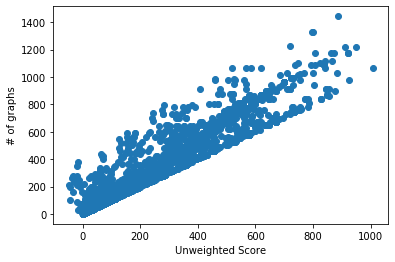

In [124]:
from scipy.stats import gaussian_kde

# Generate fake data
x = u
y = g

# # Calculate the point density
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y)

################################
#clb = plt.colorbar()
#clb.ax.set_ylabel('|actual_sim - subgraph_sim|',fontsize=10)
plt.xlabel('Unweighted Score')
plt.ylabel('# of graphs')
#plt.legend()
plt.show()

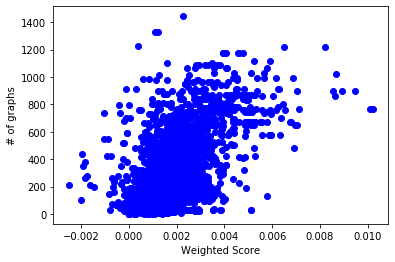

In [125]:
plt.plot(w,g, 'bo')


################################
#clb = plt.colorbar()
#clb.ax.set_ylabel('|actual_sim - subgraph_sim|',fontsize=10)
plt.xlabel('Weighted Score')
plt.ylabel('# of graphs')
#plt.legend()
plt.show()

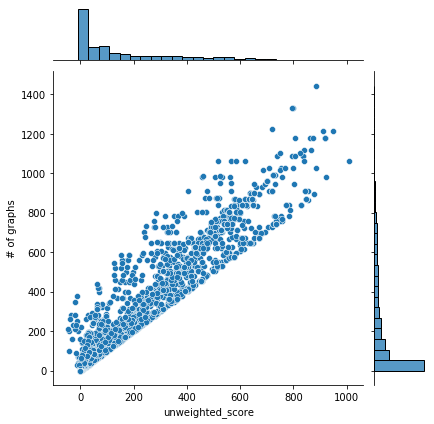

In [126]:
import pandas as pd
import seaborn as sns
#fig = plt.figure(figsize = (5,4))
df = pd.DataFrame({"unweighted_score":u, "weighted_score":w, "# of graphs":g})


sns.jointplot(data=df, x="unweighted_score", y="# of graphs")

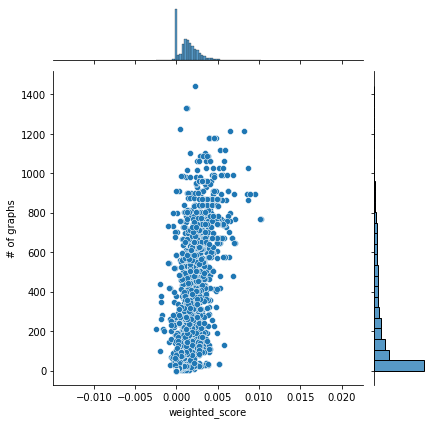

In [127]:
df = pd.DataFrame({"unweighted_score":u, "weighted_score":w, "# of graphs":g})
sns.jointplot(data=df, x="weighted_score", y="# of graphs")